<a href="https://colab.research.google.com/github/alegomezri/Image-based-EEG-Representation/blob/main/2__CAMS_GFC%2BWDCNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases
!pip install git+https://github.com/UN-GCPDS/tf-keras-vis.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pickle import load, dump
from google.colab import drive
from gcpds.databases import GIGA_MI_ME
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib
from sklearn.cluster import KMeans
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV,train_test_split

# Model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


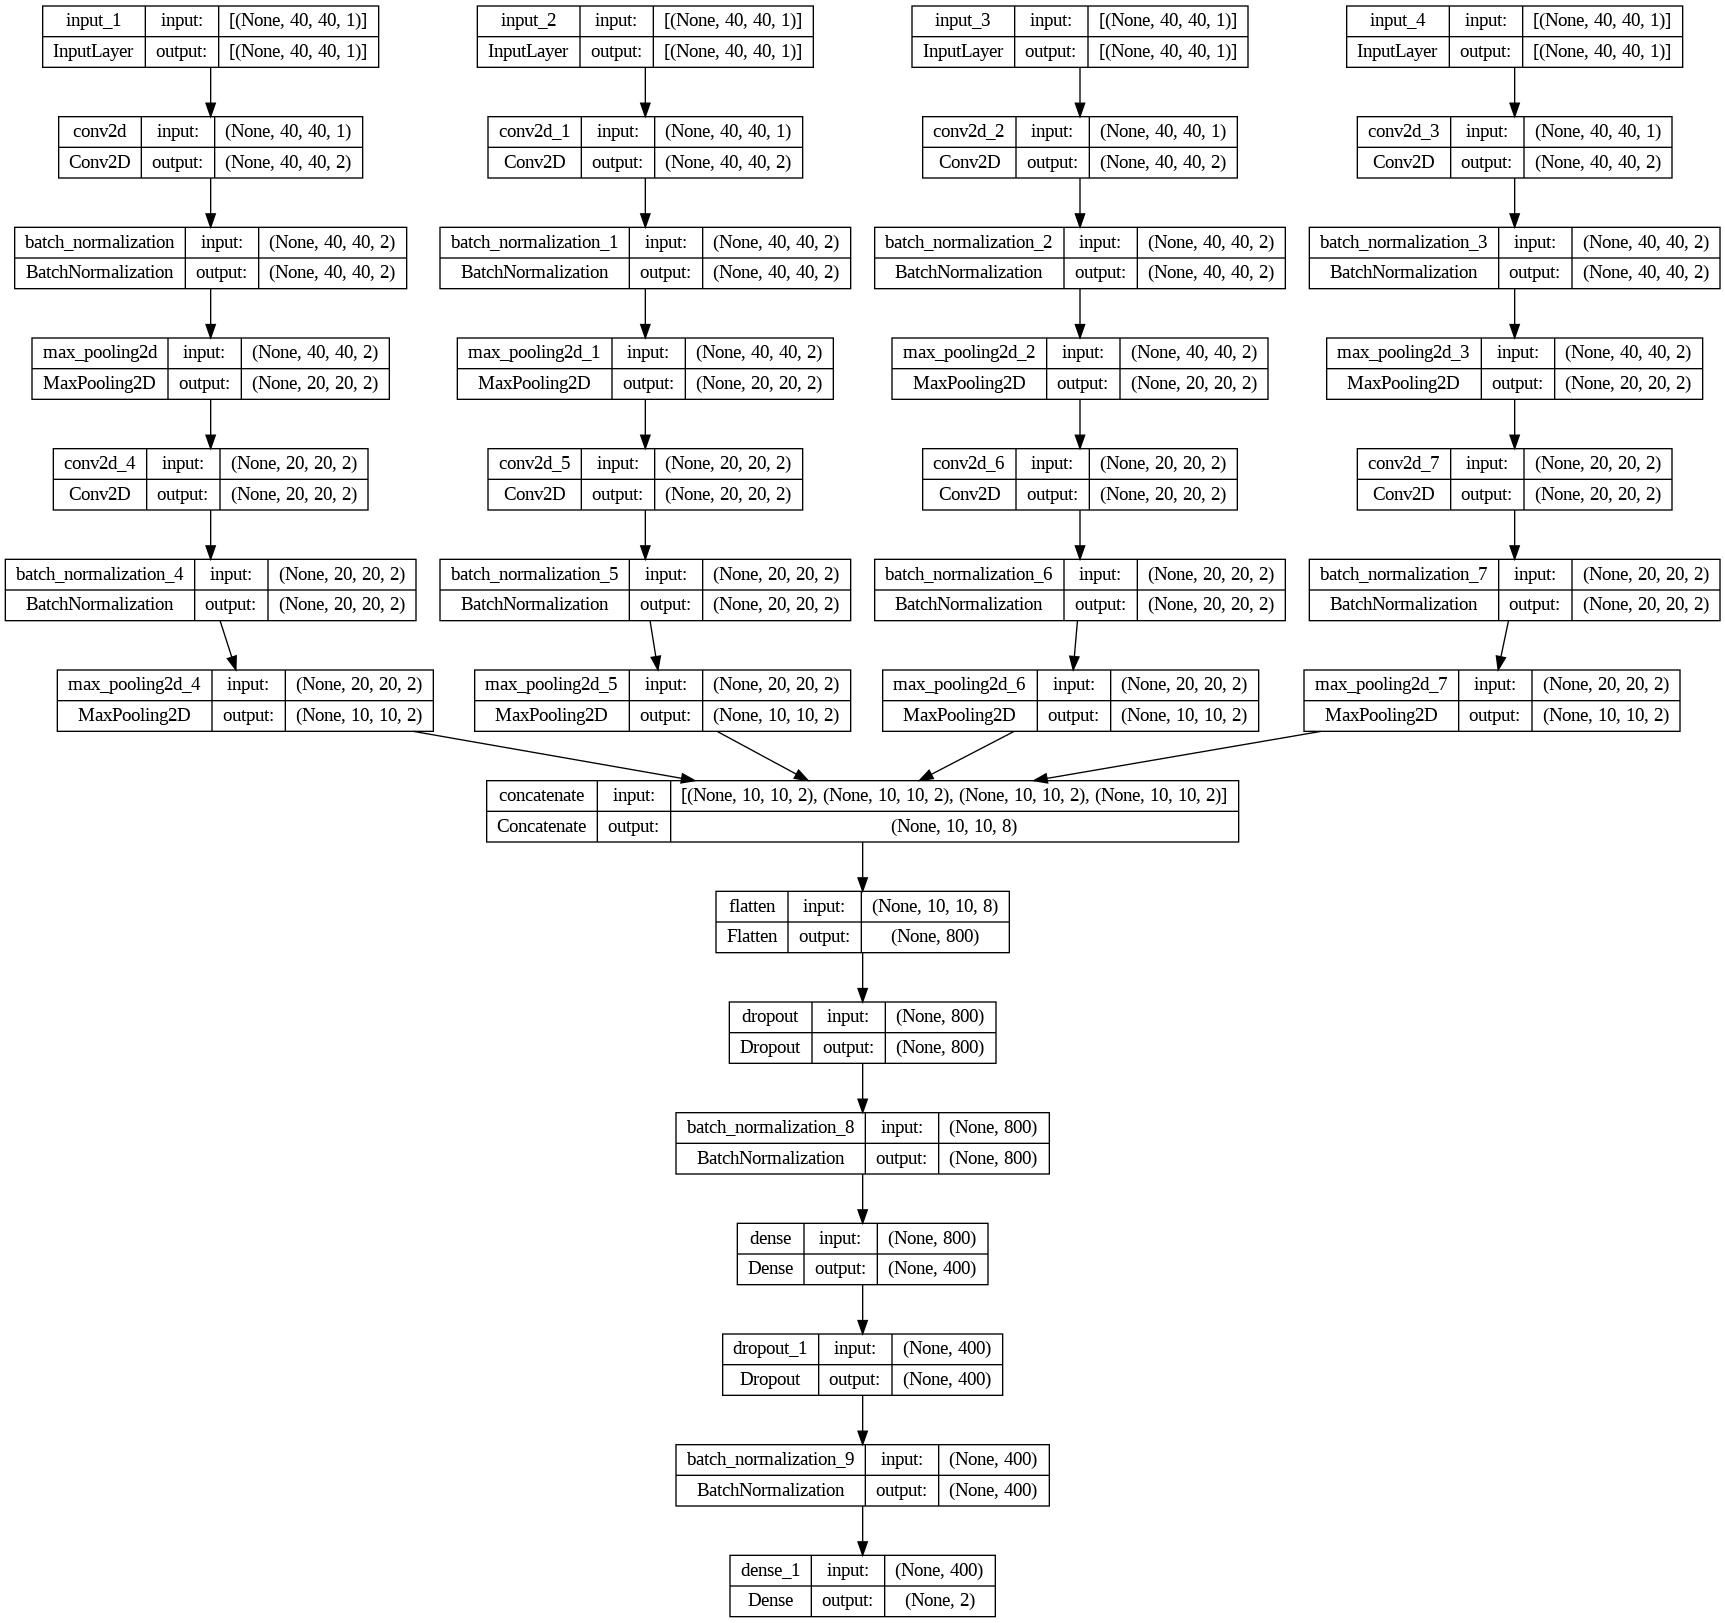

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Alejandra/PRUEBAS WDCNN/Results_Prueba_laplacian_Todos/Models/subject_43.h5")
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                              

# Functions

In [ ]:
def load_data(numero_sujeto):
  model = tf.keras.models.load_model(f"/content/drive/MyDrive/Alejandra/PRUEBAS WDCNN/Results_Prueba_laplacian_Todos/Models/subject_{numero_sujeto}.h5")
  X_gk  = np.load(f"/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2/Topograms_Prueba_laplacian_Todos/Gaussian_Kernel/sbj{numero_sujeto}.npy")
  print(X_gk .shape)
  X_gk = np.moveaxis(X_gk, -1, 4).reshape(X_gk.shape[0], X_gk.shape[1], X_gk.shape[2], X_gk.shape[3], -1)
  y  = np.load(f"/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2/Topograms_Prueba_laplacian_Todos/Targets/sbj{numero_sujeto}.npy")
  return model,X_gk , y


def score_function(labels):
  def score(output):
      r = [output[i,label] for i,label in enumerate(labels)]
      return r
  return score


def data_to_wdcnn_format(X, y):
    """
    Transform input data to the wdcnn input format
    """
    S_Mean = X.mean(axis=0)
    X_wdcnn = []
    for i in np.arange(X.shape[-1]):
      X_wdcnn.append(X[:,:,:,:,i] - S_Mean[:,:,:,i])
    return X_wdcnn,y

def load_model_short(model):
  model_shortened= tf.keras.Model(inputs=model.inputs,outputs=model.get_layer('dense').output)
  return model_shortened


In [ ]:
from skimage import segmentation
import matplotlib.cm as cm
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib as mpl
from PIL import Image,ImageOps

label2color={0:'blue',1:'yellow'}
def plot_digits(X, y, min_distance=0.01, zoom=0.5,images=None, figsize=(10, 10),s=10,cmap='viridis',colorbar='right'):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    #plt.rcParams['axes.facecolor']='white'
    fig = plt.figure(figsize=figsize)

    digits = np.unique(y)
    #cmap = mpl.cm.get_cmap("jet",len(digits))
    #for digit in digits:
    #    plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit)],s=s)
    #cmap = mpl.colors.ListedColormap(['blue', 'orange'])
    im_ = plt.scatter(X_normalized[:, 0], X_normalized[:, 1],c=y, cmap=cmap,s=s)
    #plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_facecolor('white')#(0.1,0.1,0.1,0.25))
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if np.all(images) != None:
                #image = images[index].reshape(28, 28)
                image= images[index][...,0]
                imagebox = AnnotationBbox(OffsetImage(image, cmap="viridis",
                                                      zoom=zoom,alpha=0.6),
                                           image_coord,xycoords='data', frameon=True, bboxprops=dict(fc='white', edgecolor=label2color[y[index]], alpha=1))
                ax.add_artist(imagebox)
                ax.autoscale()
        unv = np.unique(y)
    if colorbar == 'right':
      cax = fig.add_axes([0.915, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))

    elif colorbar == 'left':
      cax = fig.add_axes([0.085, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))
      cax.yaxis.tick_left()




def plot_digits_AM(X, y, s,Cams,images,NN=False,min_distance=0.01,zoom=0.5,figsize=(10, 10),max_c = 100,spercentile=90,cmap='jet',colorbar='right'):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    fig = plt.figure(figsize=figsize)
    #mpl.cm.get_cmap("jet",len(np.unique(y)))
    digits = np.unique(y)
    #for digit in digits:
    im_ = plt.scatter(X_normalized[:, 0], X_normalized[:, 1],c=y, cmap=cmap,s=s)
    #plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor((0.1,0.1,0.1,0.25))


    ax = plt.gcf().gca()  # get current axes in current figure
    #plotting according to L2 distance
    if NN:
      for index, image_coord in enumerate(X_normalized):
          closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
          if closest_distance > min_distance:
              heatmap = Image.fromarray(np.uint8(cm.jet(Cams[index])[..., :3] * 255)).convert('L')
              heatmap = ImageOps.colorize(heatmap, black ="white", white ="red")


              neighbors = np.r_[neighbors, [image_coord]]
              #image = images[index].reshape(28, 28)
              image= images[index]
              imagebox = AnnotationBbox(OffsetImage(image, cmap="binary",zoom=zoom,alpha=0.7), image_coord,xycoords='data', frameon=False)
              ax.add_artist(imagebox)
              im = OffsetImage(heatmap,zoom=zoom,alpha=0.6)

              imagebox = AnnotationBbox(im, image_coord,xycoords='data', frameon=False)
              ax.add_artist(imagebox)
              ax.autoscale()

    #plotting according to s
    sper = np.percentile(s,spercentile)
    inds = np.arange(len(s))[s>sper]
    if len(inds) > max_c: inds = inds[:max_c]

    for index in inds:
      heatmap = Image.fromarray(np.uint8(cm.jet(Cams[index])[..., :3] * 255)).convert('L')
      heatmap = ImageOps.colorize(heatmap, black ="white", white ="red")
      image = images[index].reshape(28, 28)
      imagebox = AnnotationBbox(OffsetImage(image, cmap="binary",zoom=zoom,alpha=0.7), X_normalized[index],xycoords='data', frameon=False)
      ax.add_artist(imagebox)
      im = OffsetImage(heatmap,zoom=zoom,alpha=0.6)
      imagebox = AnnotationBbox(im, X_normalized[index],xycoords='data', frameon=False)
      ax.add_artist(imagebox)
      ax.autoscale()

    unv = np.unique(y)
    #colorbar
    if colorbar == 'right':
      cax = fig.add_axes([0.915, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))

    elif colorbar == 'left':
      cax = fig.add_axes([0.085, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))
      cax.yaxis.tick_left()

In [ ]:
model ,X_gk ,y= load_data(1)
data_to_wdcnn_format(X_gk,y)
X_gk,y= data_to_wdcnn_format(X_gk,y)

(200, 40, 40, 1, 1, 4)


In [ ]:
def calculate_cam(model, X, class_):
    layers = ['conv2d','conv2d_1','conv2d_2','conv2d_3']

    target_class = np.ones(len(X[0]),dtype=np.uint8)*class_
    cams = []
    for i,lay in enumerate(layers):
        replace2linear = ReplaceToLinear()
        # Create GradCAM++ object
        gradcam = GradcamPlusPlus(model,
                                  model_modifier=replace2linear,
                                  clone=True)

        # Generate heatmap with GradCAM++
        cam = gradcam(score_function(target_class),
                      X,
                      penultimate_layer=lay,
                      normalize_cam=False,
                      seek_penultimate_conv_layer=False)
        cams.append(cam[i][...,None])

    cams = np.concatenate(cams, axis=-1)
    return cams


In [ ]:
db = GIGA_MI_ME('/content/drive/Shareddrives/GCPDS/databases/GIGA-MI_ME/')
subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects,[28,33])
save_path = '/content/drive/MyDrive/Alejandra/PRUEBAS WDCNN/CAMS_2'

# CAMS

In [ ]:
for sbj in subjects:
  print('GradCAM Subjet: ',sbj)
  model, X_gk, y= load_data(sbj)
  Xtrain, Xtest, ytrain,ytest = train_test_split(X_gk,y,test_size=0.2,random_state=0)
  Xtest, ytest = data_to_wdcnn_format( Xtest,ytest)

  cams_per_class = []
  for class_ in [0,1]:
      cams = calculate_cam(model, Xtest, class_)
      cams_per_class.append(cams[...,None])

  cams_per_class = np.concatenate(cams_per_class, axis=-1 )

  DTYPE = np.dtype([('y', np.int64, len(ytest)),
                  ('cam', np.float32, cams_per_class.shape)
                 ])
  data_cam = np.zeros(1, dtype=DTYPE)
  data_cam[0] = ytest,cams_per_class

  np.save(save_path+'/GradCAM++_subject_all_classes'+ str(sbj)+'.npy', data_cam)#[capas, bandas(entradas), trials, imagen ]

GradCAM Subjet:  1
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  2
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  3
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  4
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  5
(199, 40, 40, 1, 1, 4)
GradCAM Subjet:  6
(178, 40, 40, 1, 1, 4)
GradCAM Subjet:  7
(240, 40, 40, 1, 1, 4)
GradCAM Subjet:  8
(198, 40, 40, 1, 1, 4)
GradCAM Subjet:  9
(240, 40, 40, 1, 1, 4)
GradCAM Subjet:  10
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  11
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  12
(174, 40, 40, 1, 1, 4)
GradCAM Subjet:  13
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  14
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  15
(191, 40, 40, 1, 1, 4)
GradCAM Subjet:  16
(199, 40, 40, 1, 1, 4)
GradCAM Subjet:  17
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  18
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  19
(143, 40, 40, 1, 1, 4)
GradCAM Subjet:  20
(83, 40, 40, 1, 1, 4)
GradCAM Subjet:  21
(199, 40, 40, 1, 1, 4)
GradCAM Subjet:  22
(200, 40, 40, 1, 1, 4)
GradCAM Subjet:  23
(197, 40, 40, 1, 1, 4)
GradCAM Subjet:  24
(

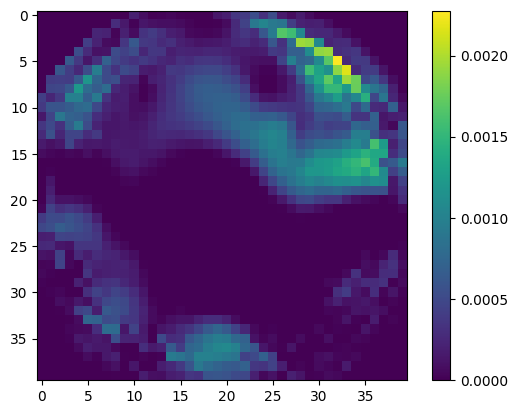

In [ ]:
plt.imshow(cams[20, :, :, 0])
plt.colorbar();

In [ ]:
import tensorflow as tf
def load_cam_data(subj):
    data = np.load(save_path+'/GradCAM++_subject_all_classes'+ str(subj)+'.npy')#[capas, bandas(entradas), trials, imagen ]
    y = data['y'][0]
    cams = data['cam'][0]
    return cams, y


def plot_by_subj(subj):
    cams, y = load_cam_data(subj)
    index= np.argsort(y)
    vnorm = np.array(tf.reduce_sum(cams[index], axis=[1,2,3])/(40*40*4))
    vnorm = vnorm/(vnorm.sum(axis=1, keepdims=True) + 1e-10)
    plt.pcolormesh(vnorm, vmax=1, vmin=0)
    plt.title(f'Subject {subj}')
    plt.colorbar()
    plt.show()

def box_plot(subj):
    xticks= 0,1
    cams, y = load_cam_data(subj)
    vnorm = np.array(tf.reduce_sum(cams, axis=[0,1,2])/(40*40*4))
    vnorm = vnorm/(vnorm.sum(axis=1, keepdims=True) + 1e-10) #normalizing using classes
    plt.boxplot(vnorm)
    plt.boxplot(xticks)
    plt.title(f'Subject {subj}')
    plt.show()


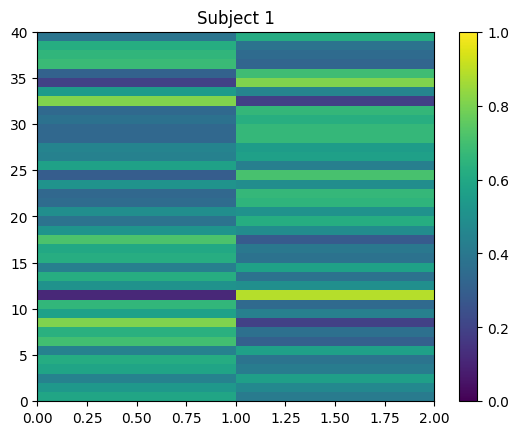

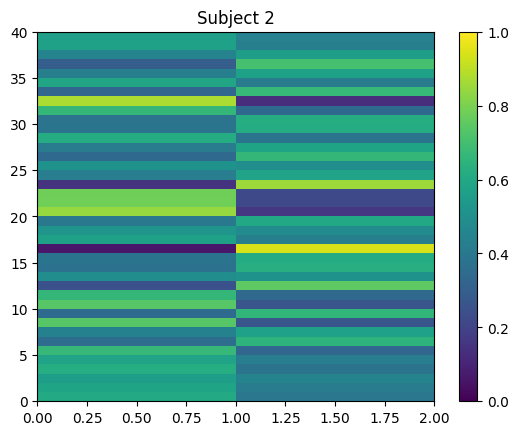

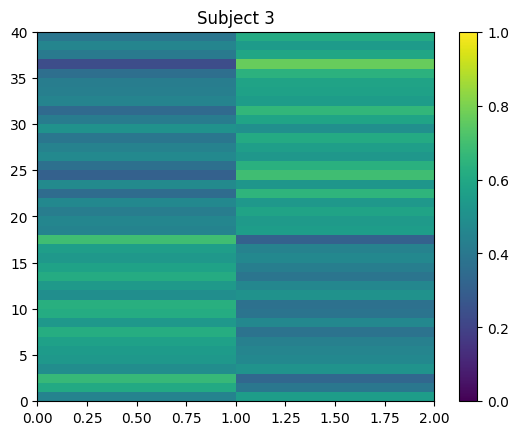

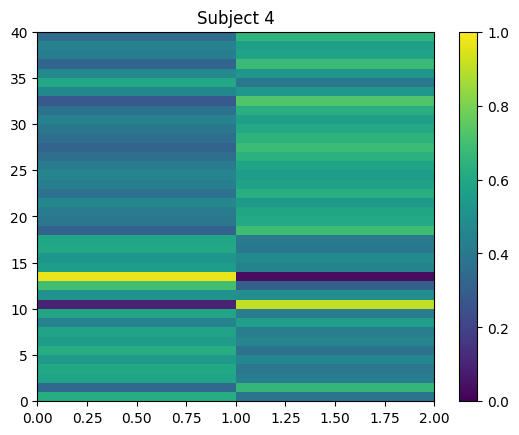

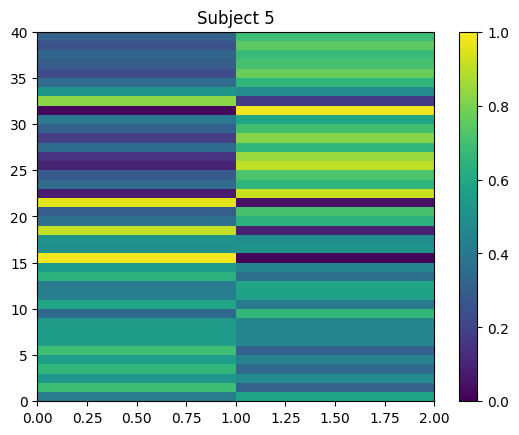

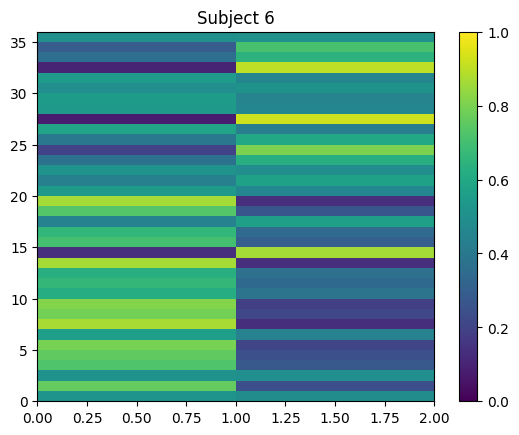

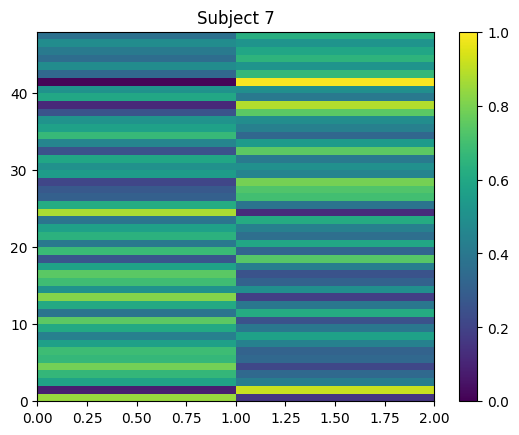

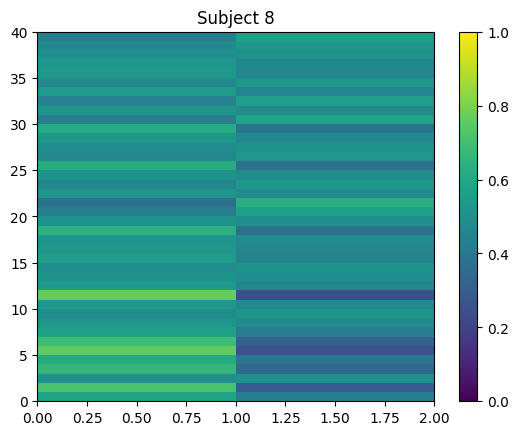

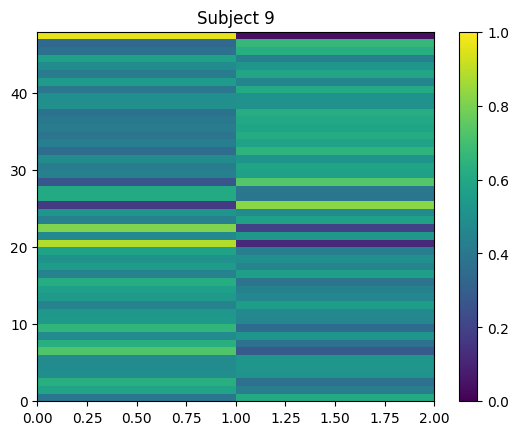

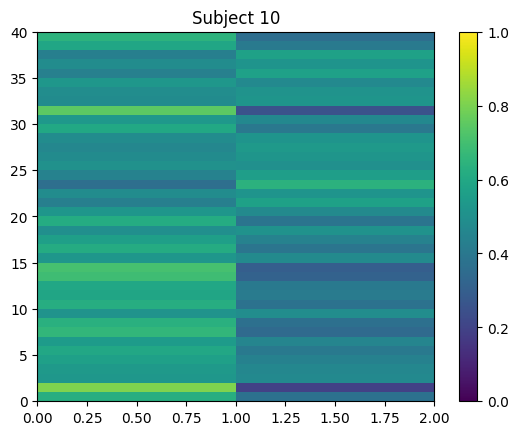

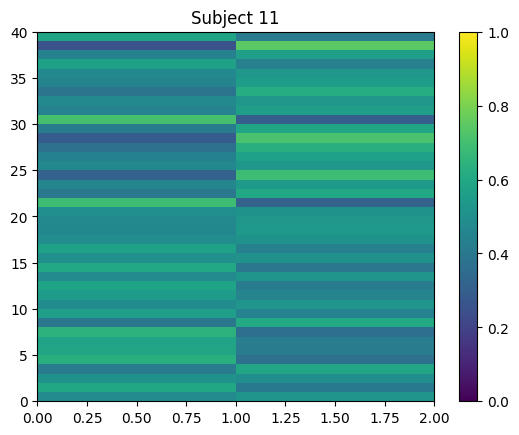

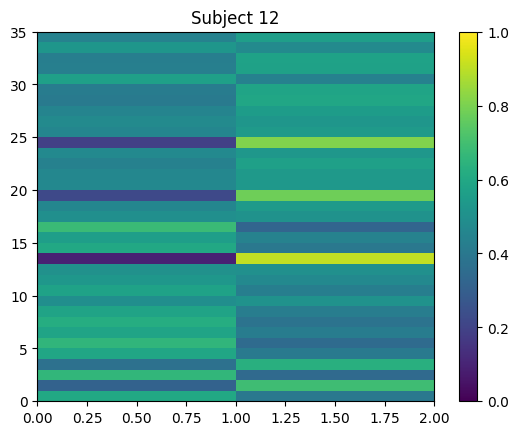

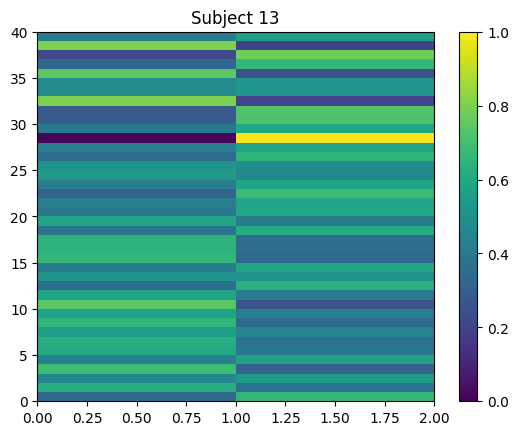

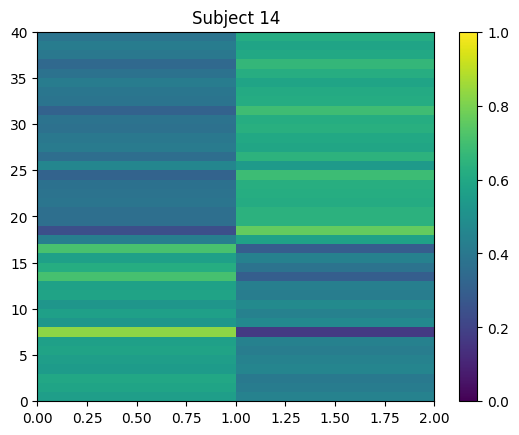

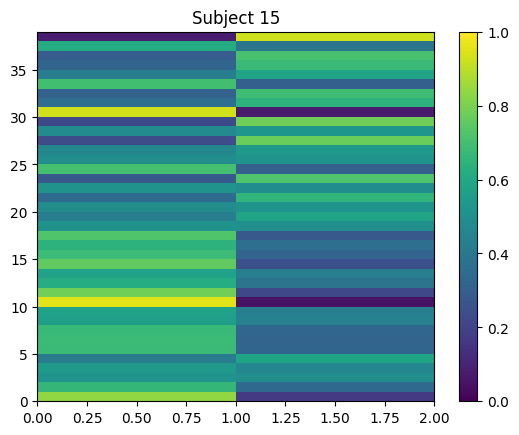

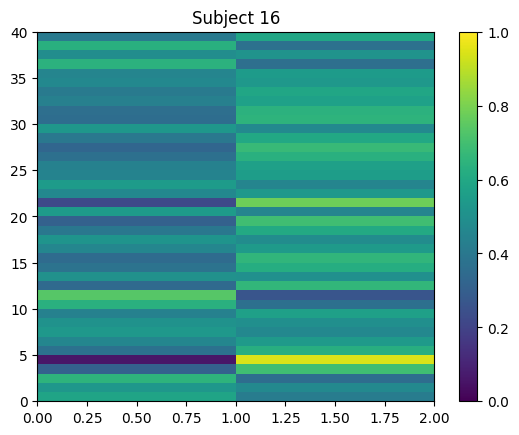

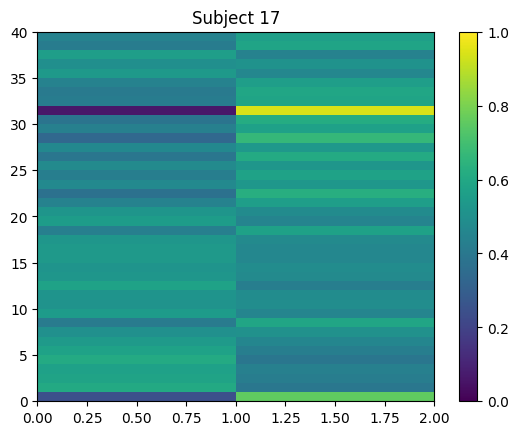

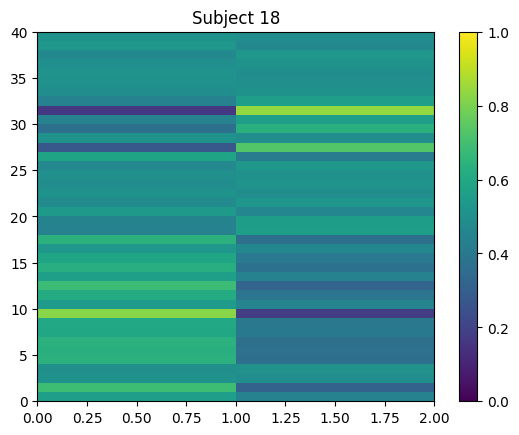

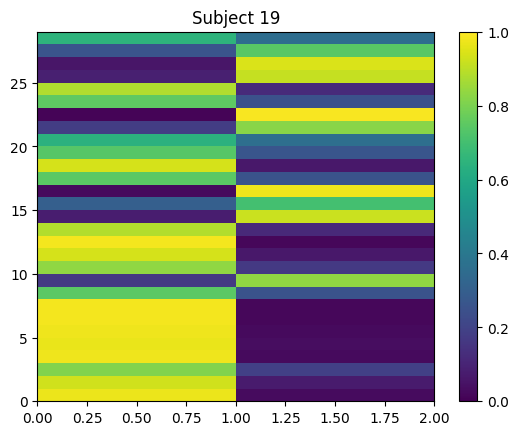

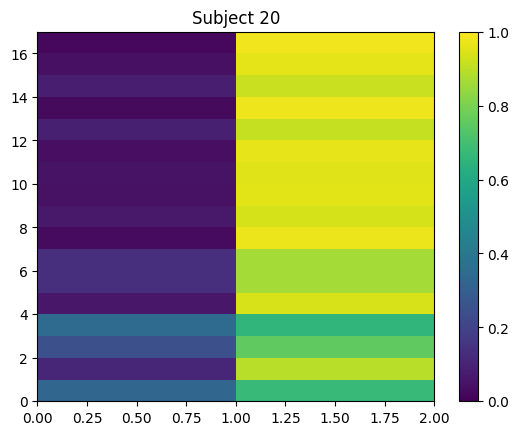

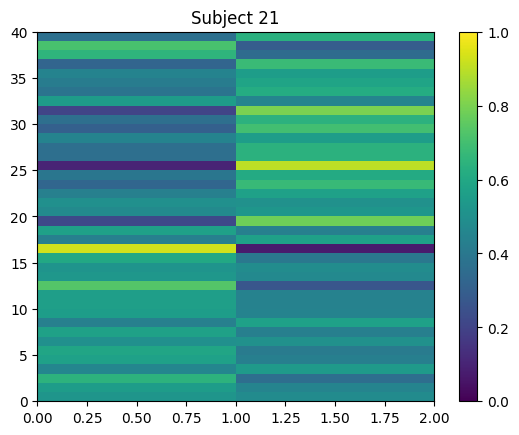

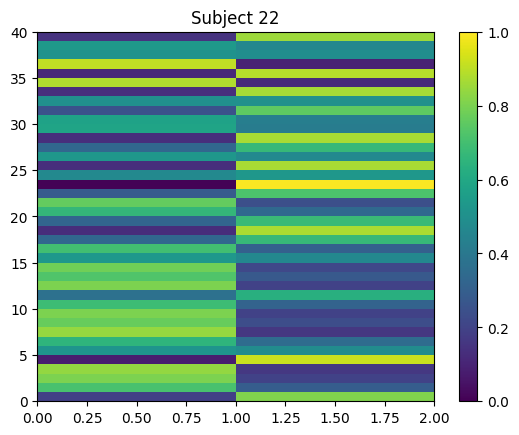

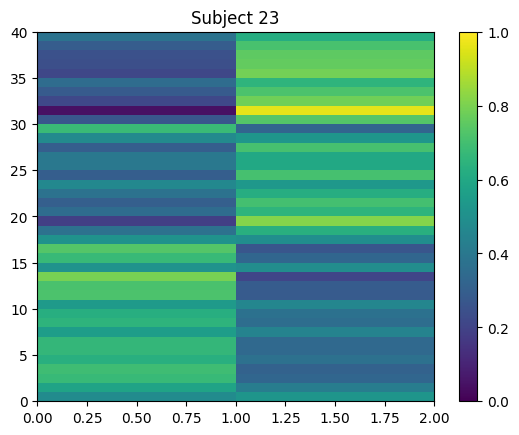

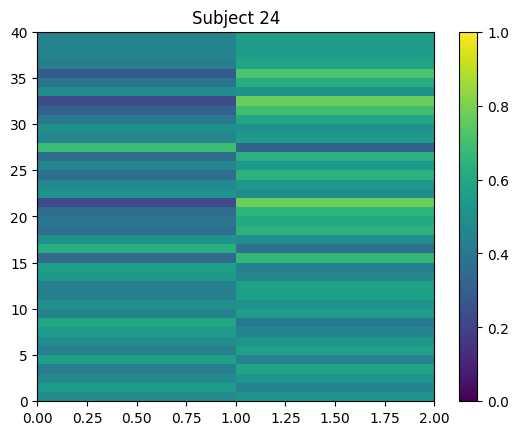

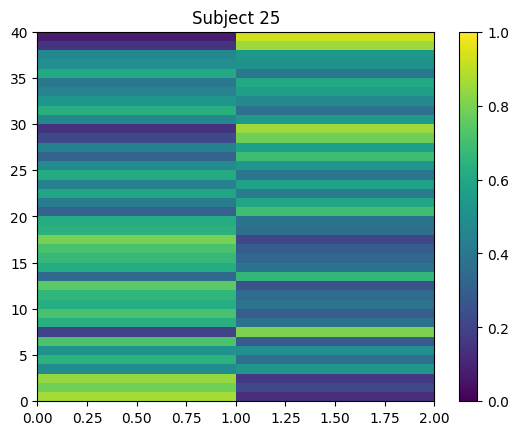

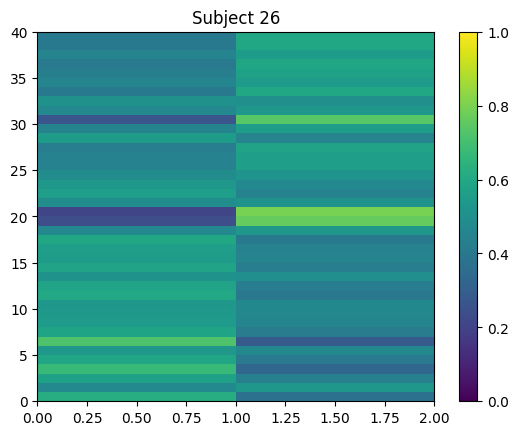

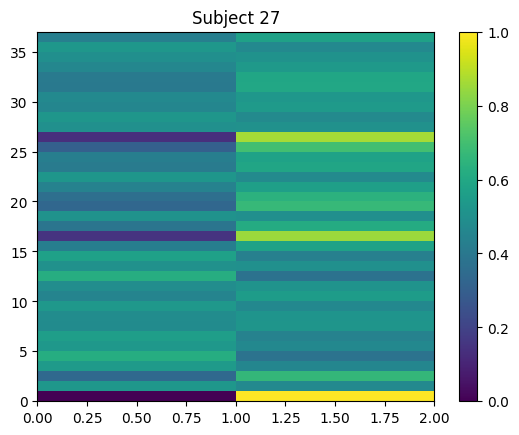

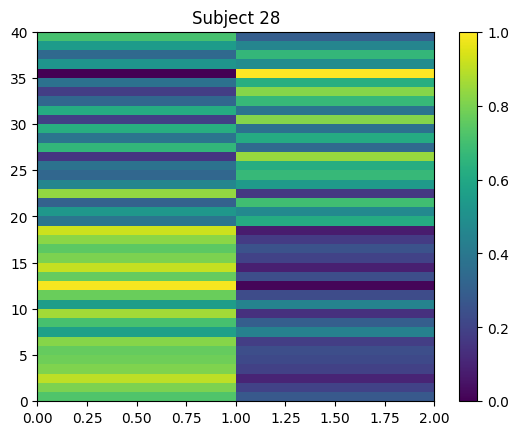

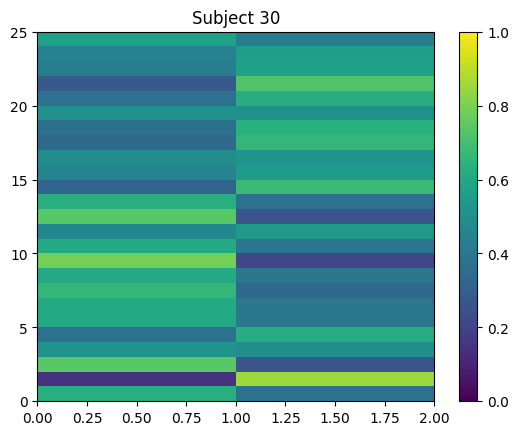

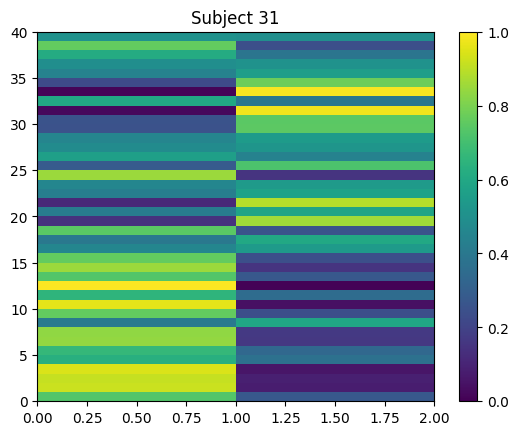

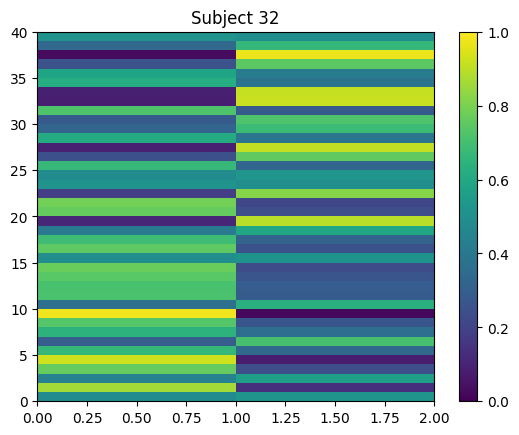

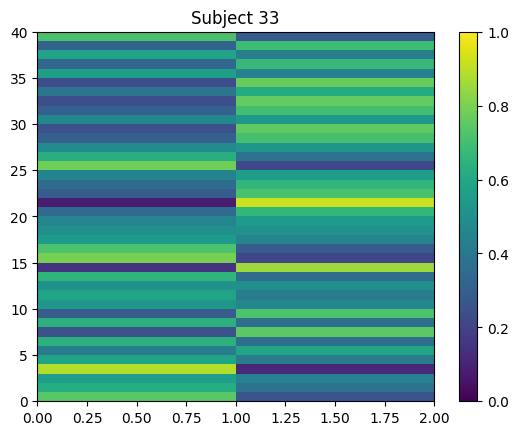

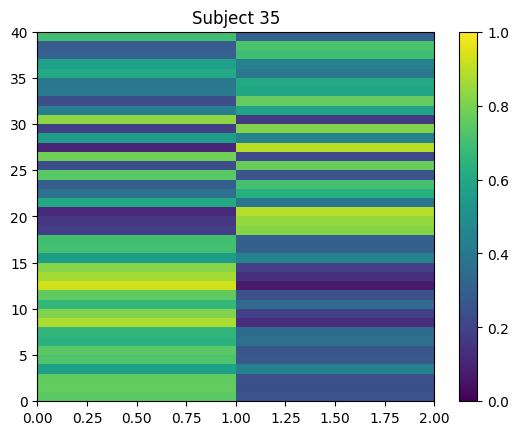

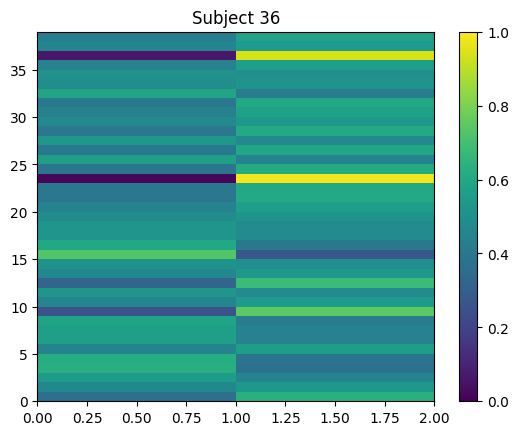

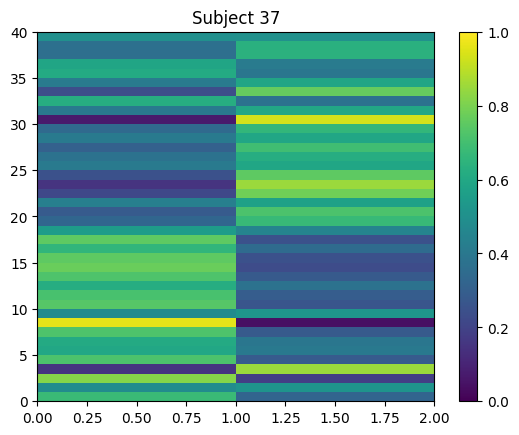

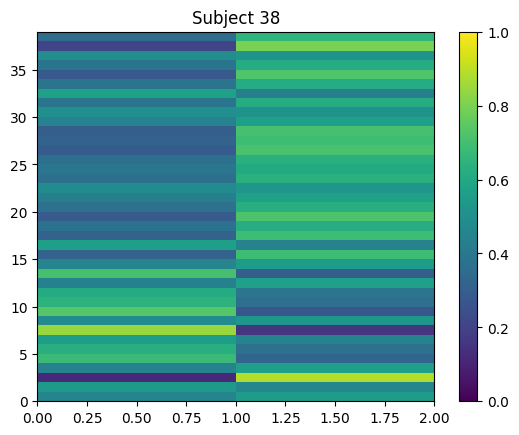

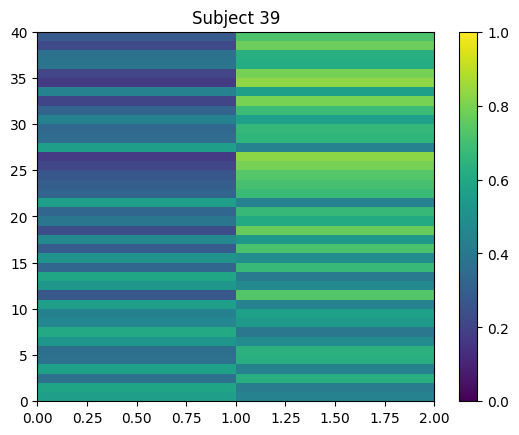

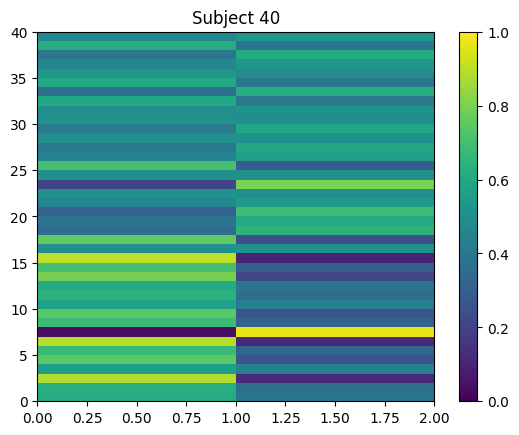

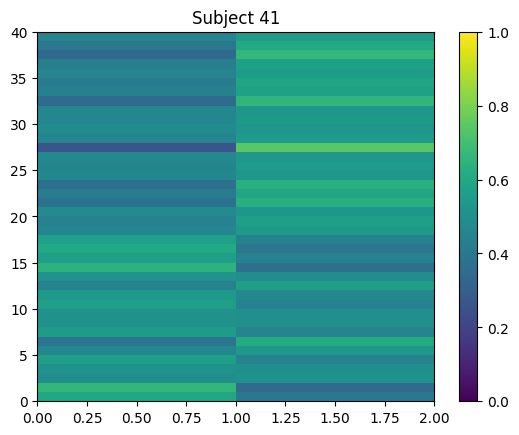

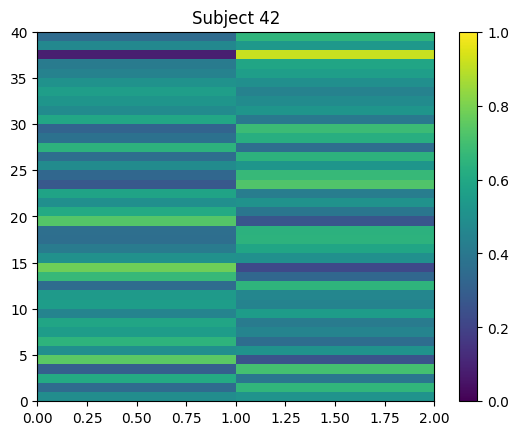

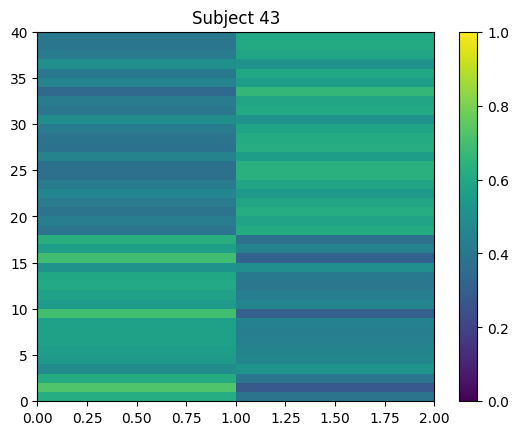

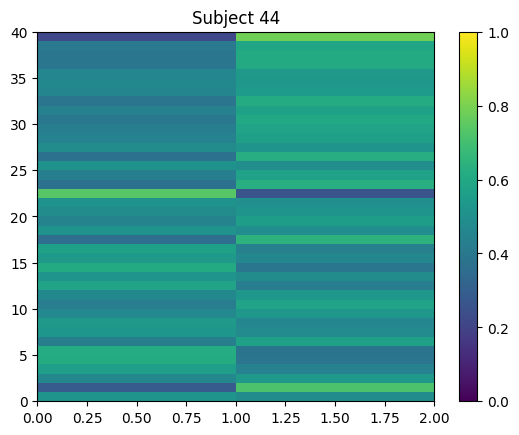

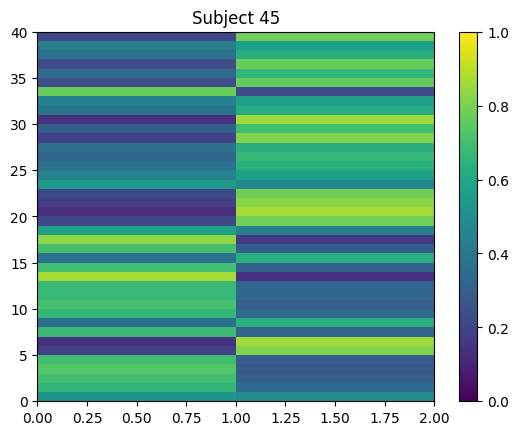

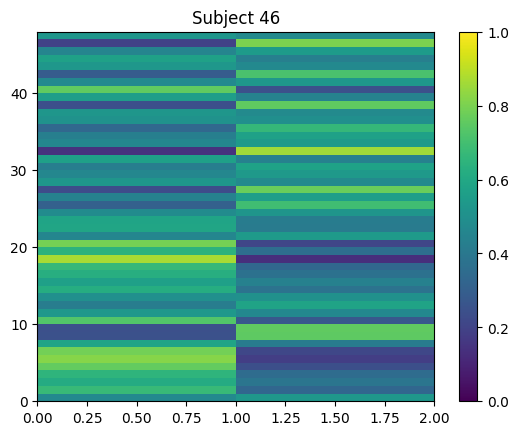

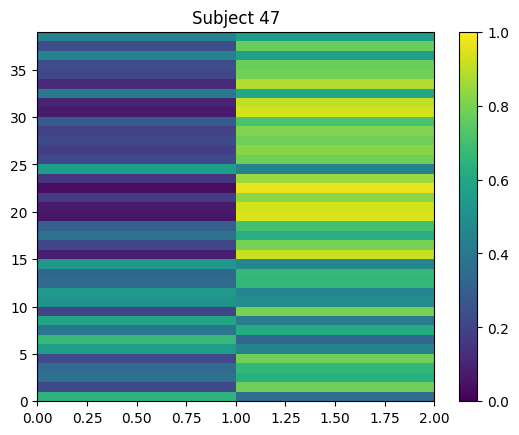

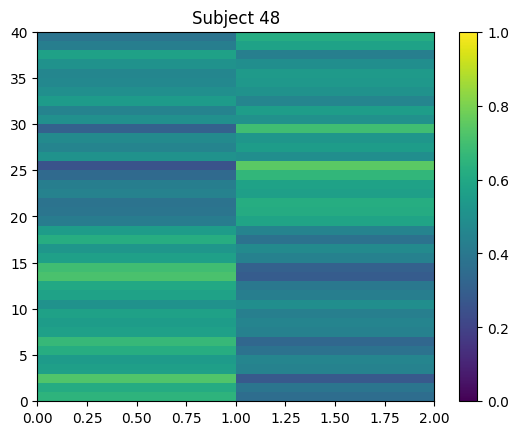

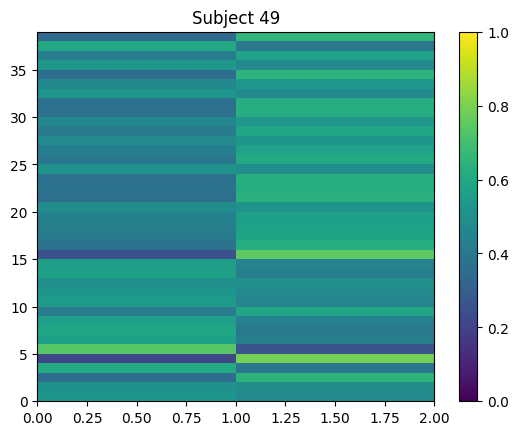

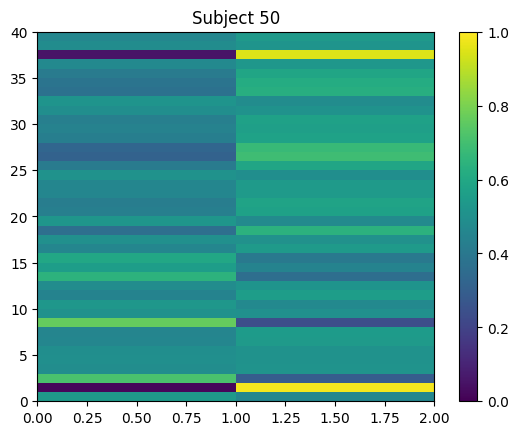

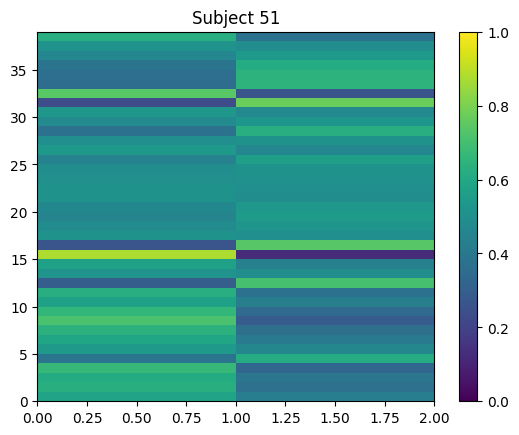

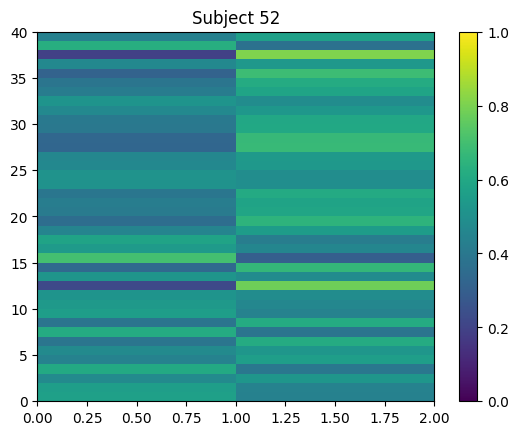

In [ ]:
#normalizing cams energy
for i in subjects:
    plot_by_subj(i)

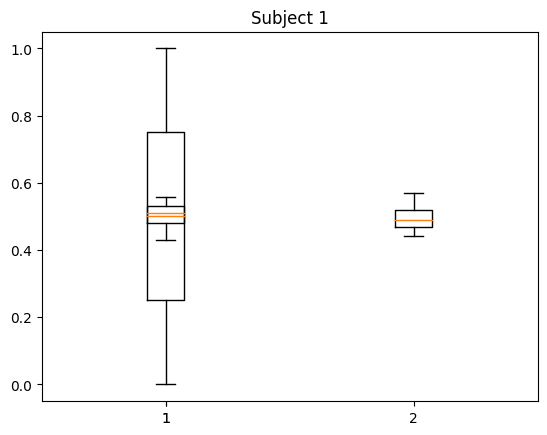

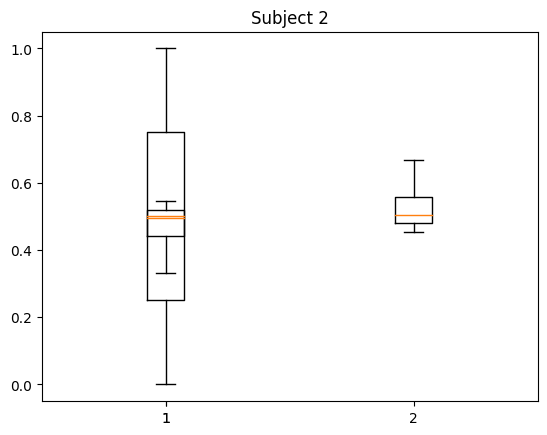

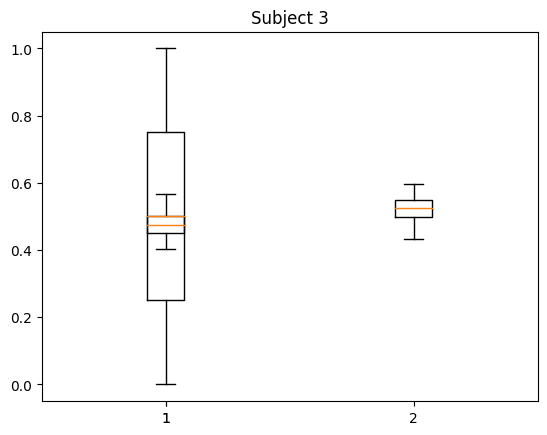

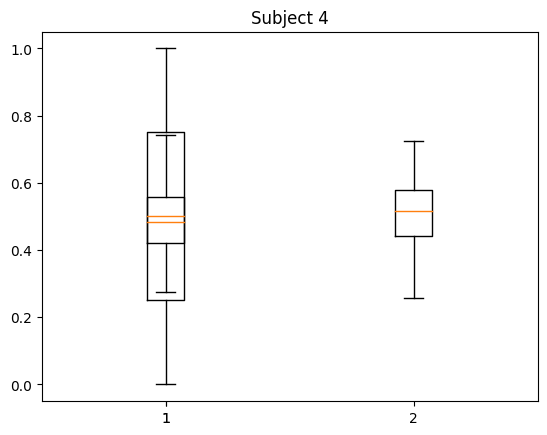

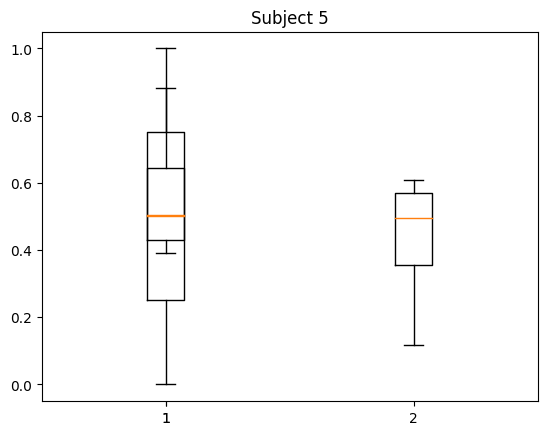

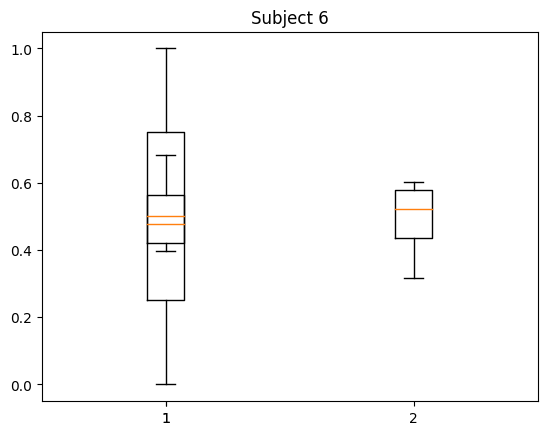

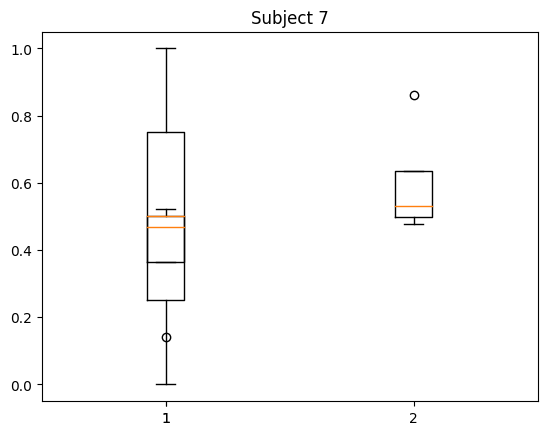

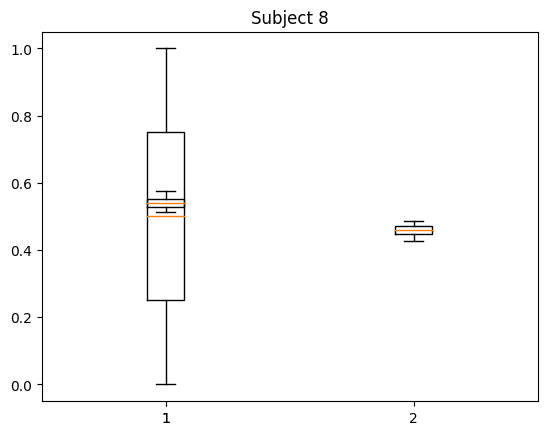

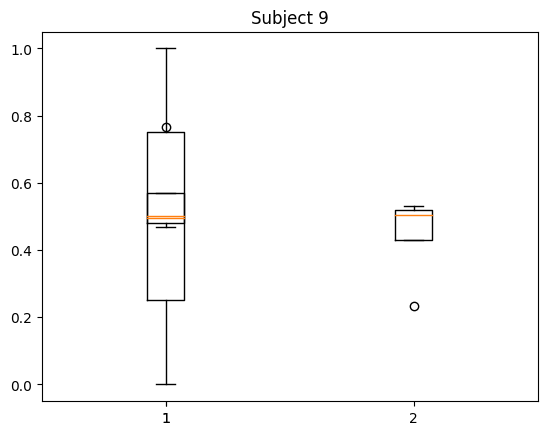

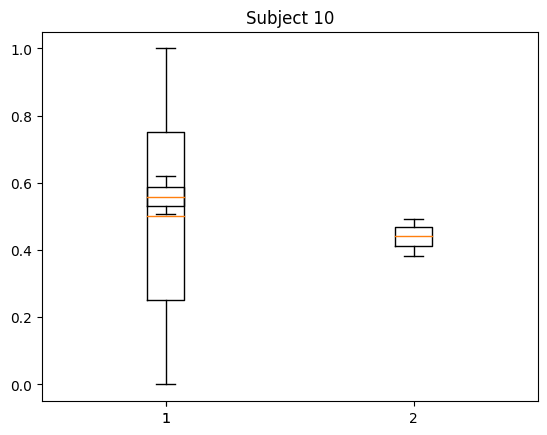

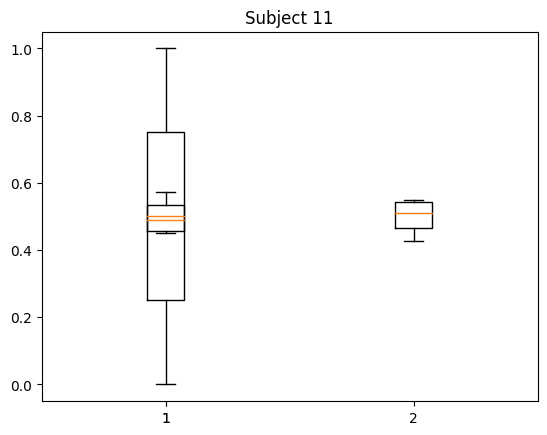

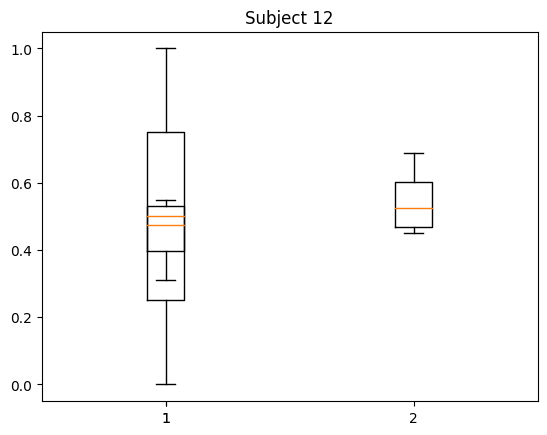

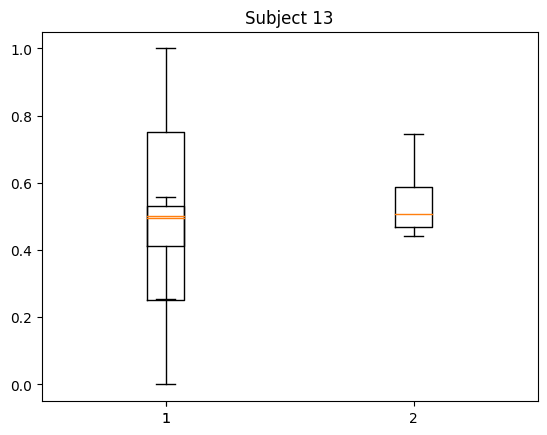

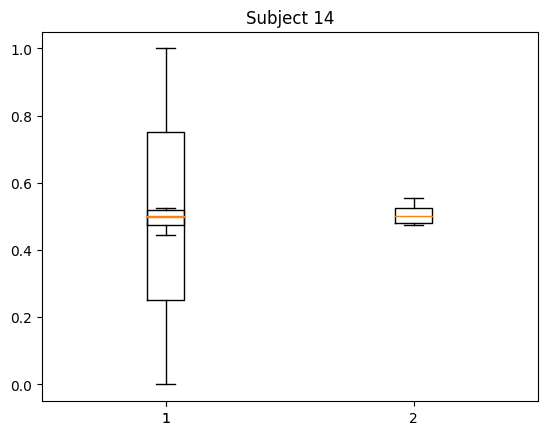

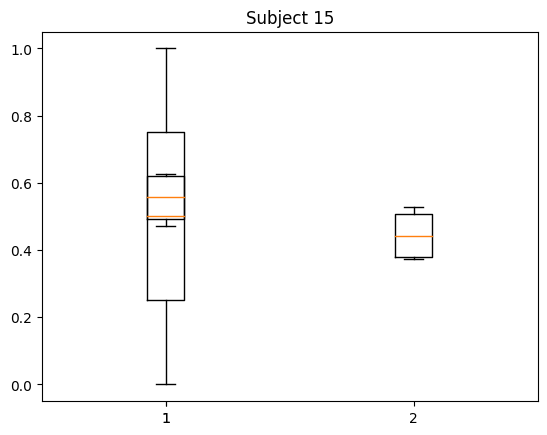

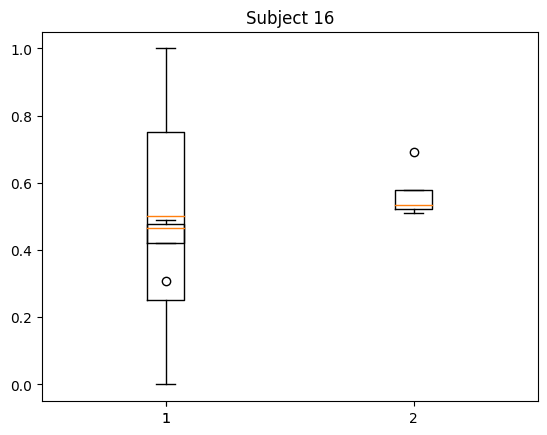

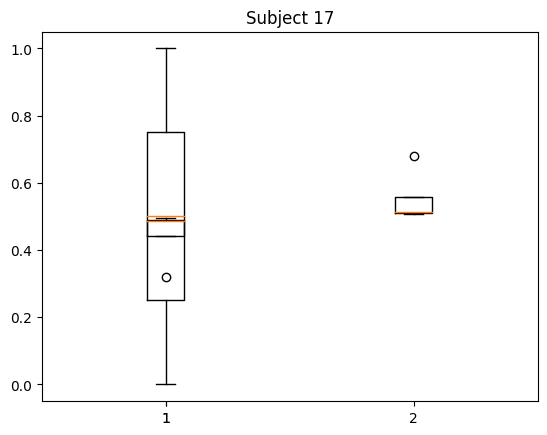

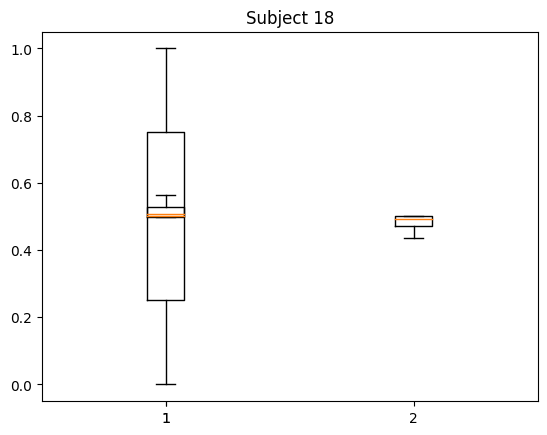

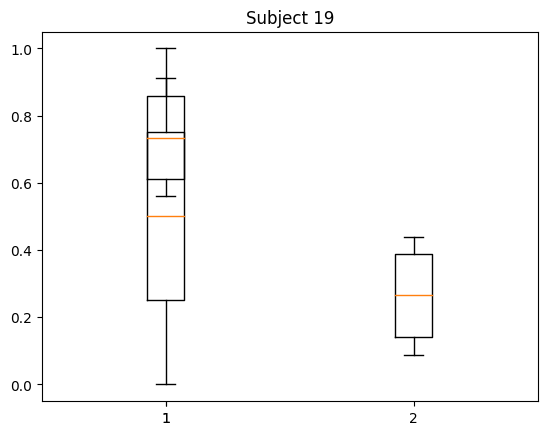

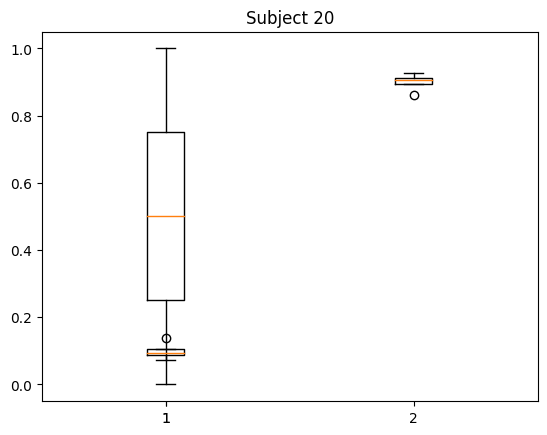

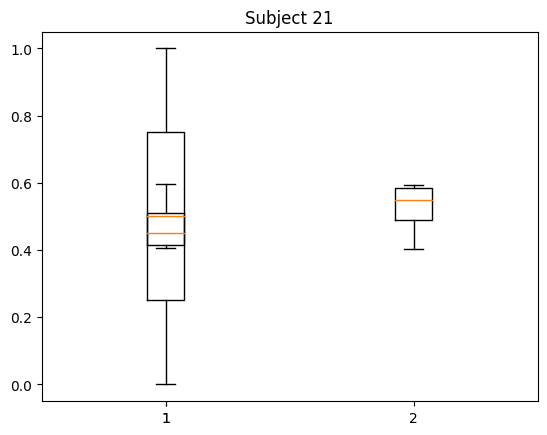

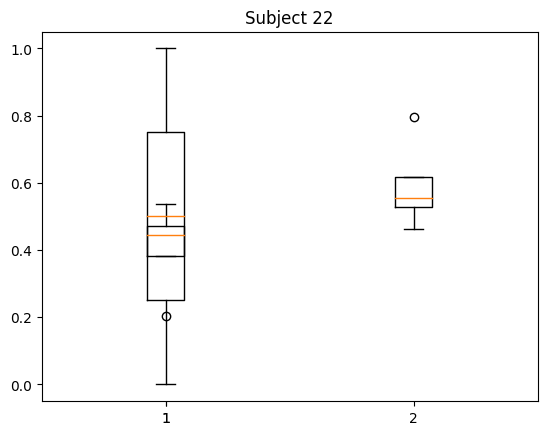

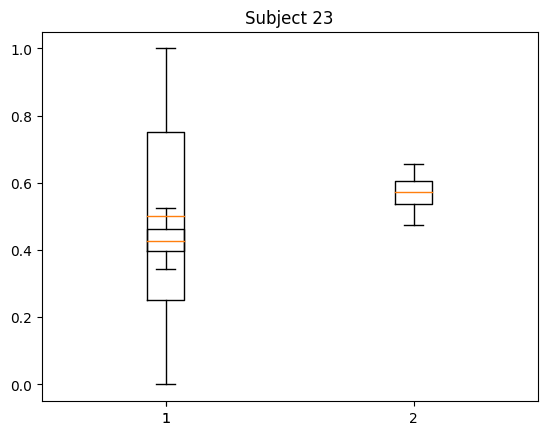

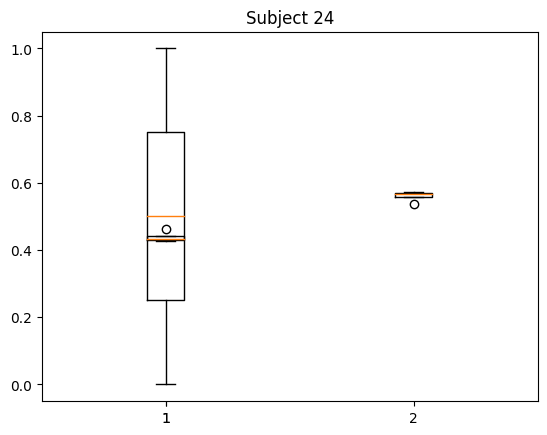

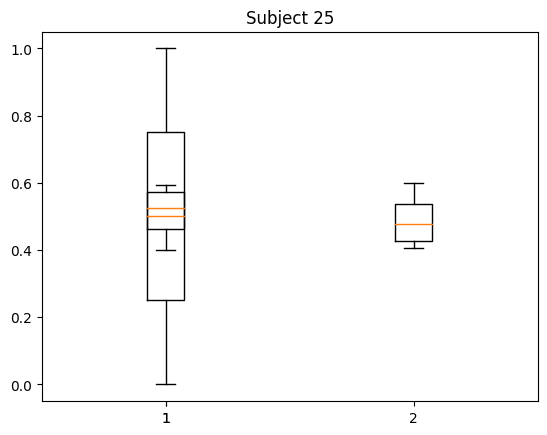

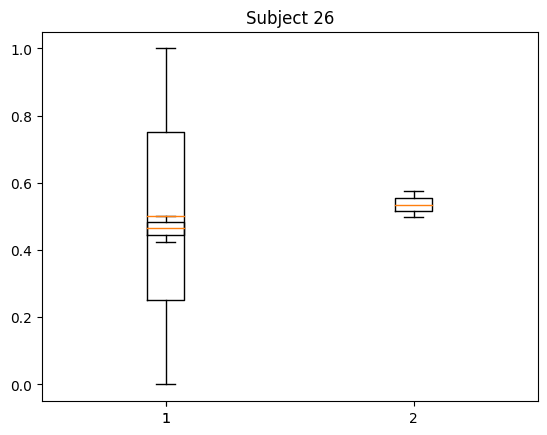

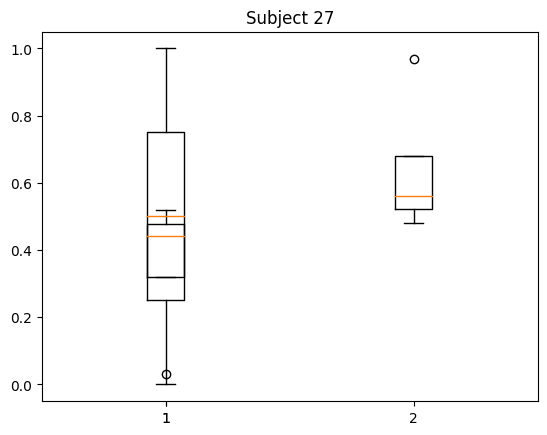

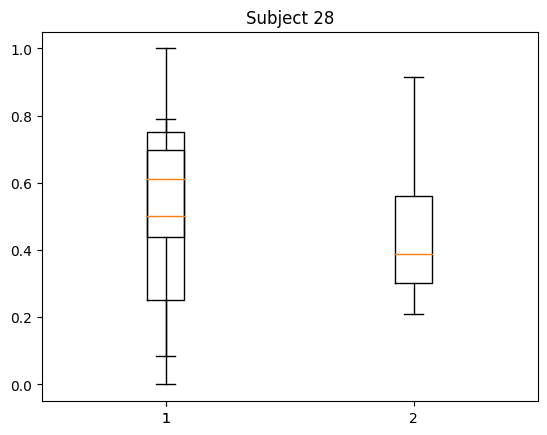

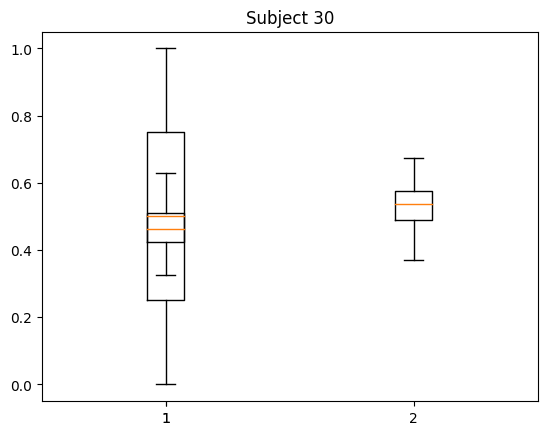

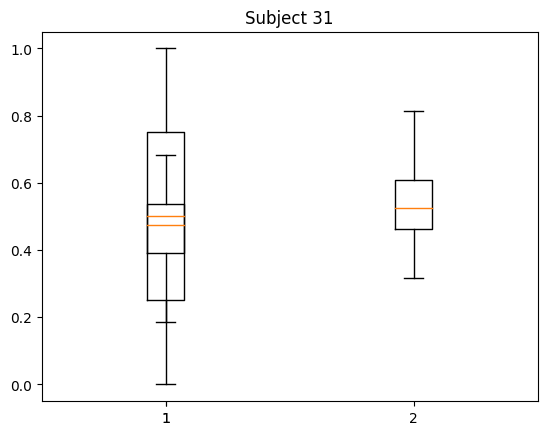

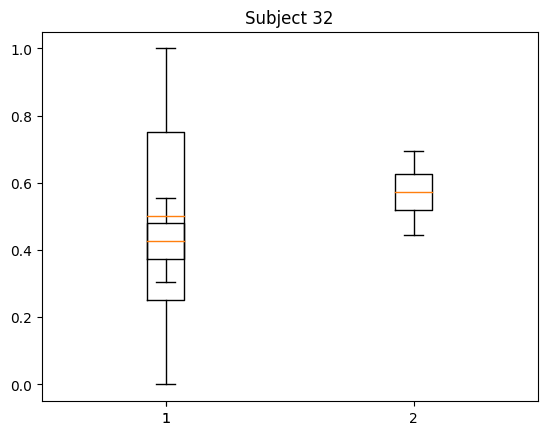

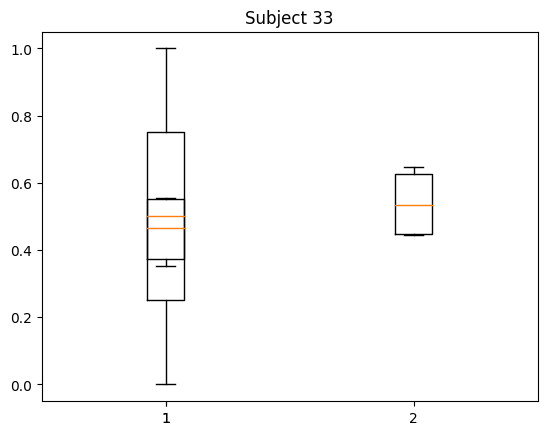

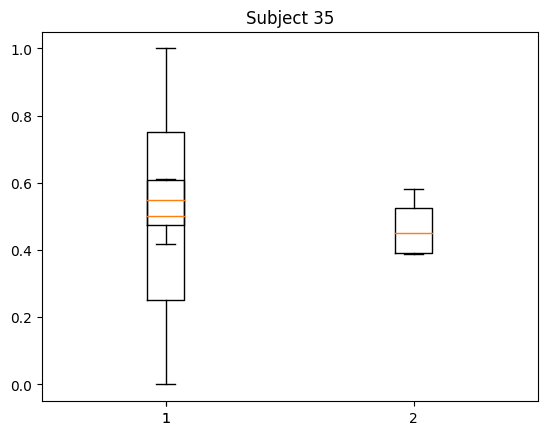

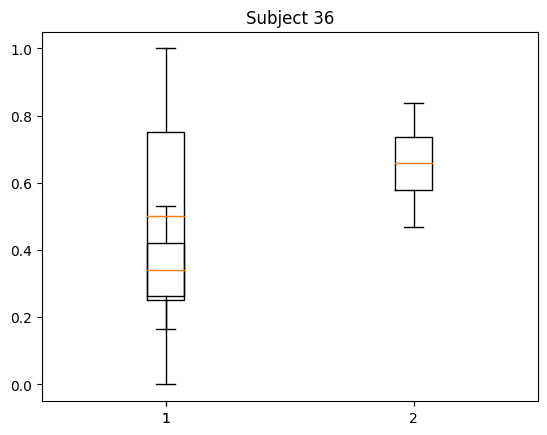

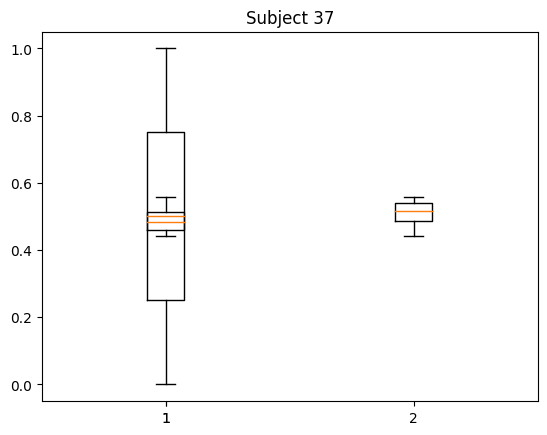

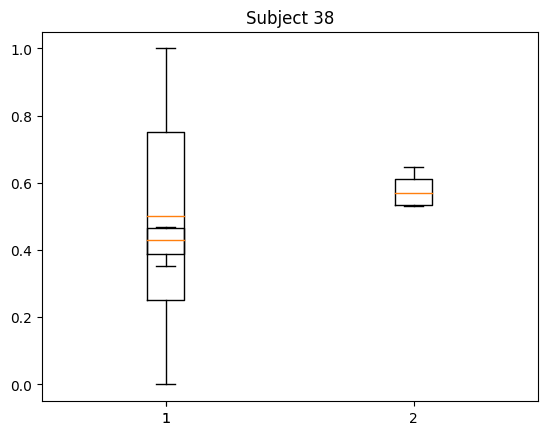

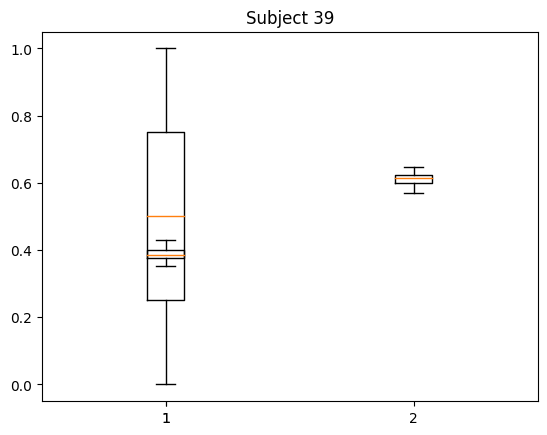

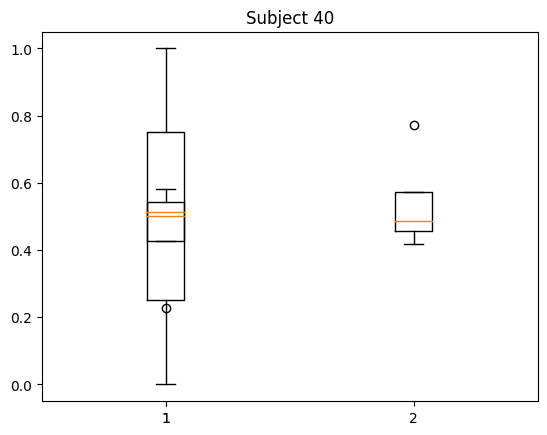

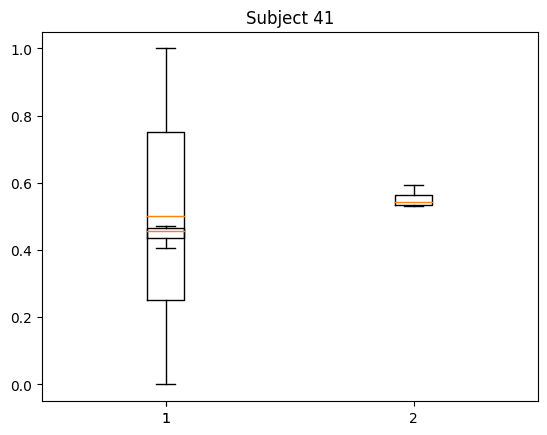

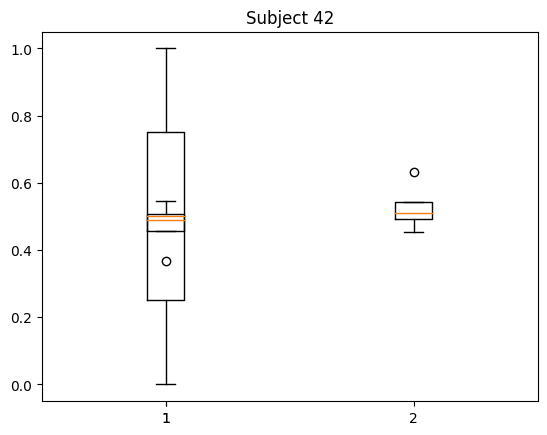

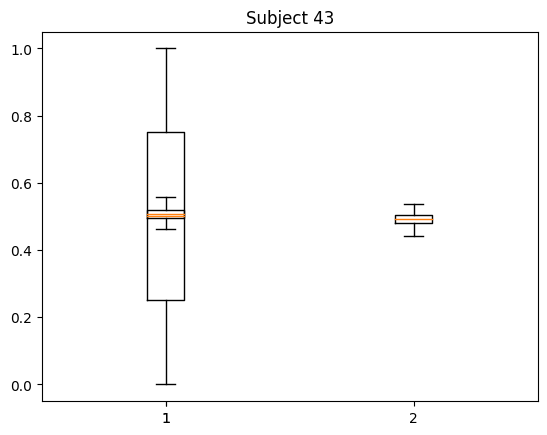

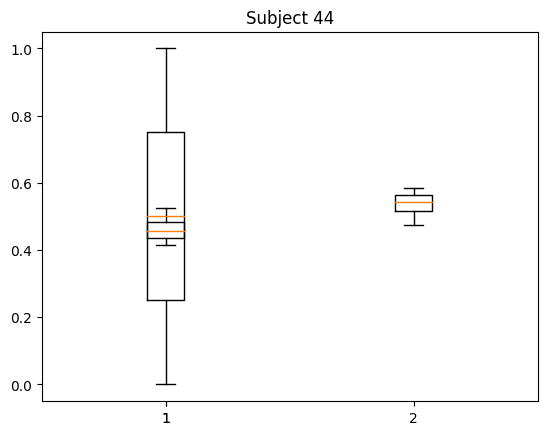

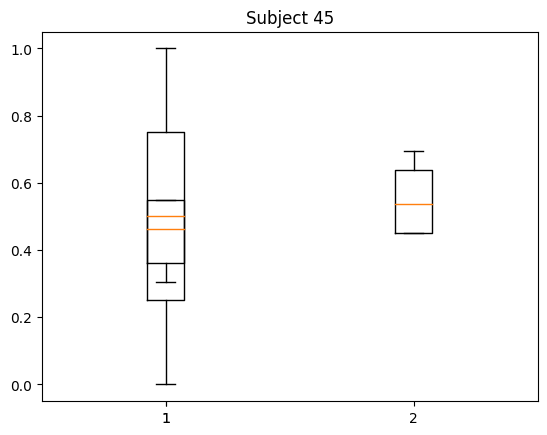

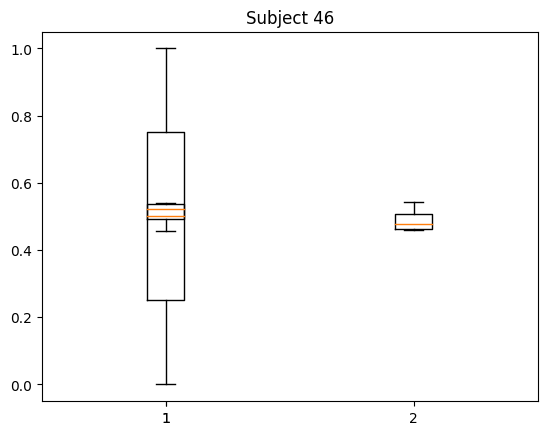

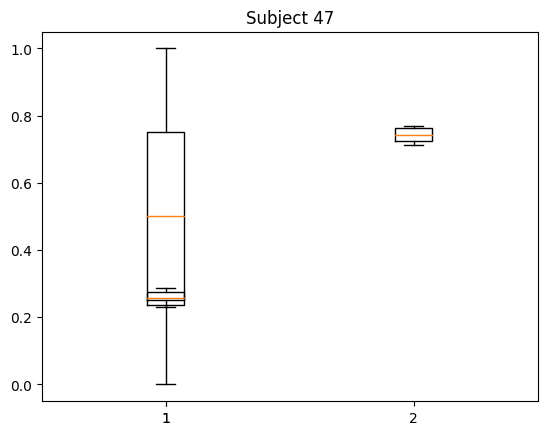

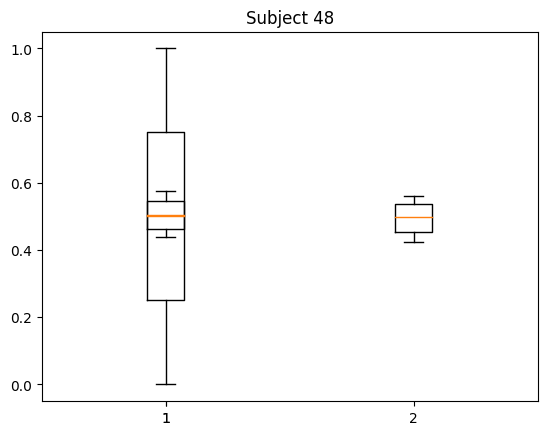

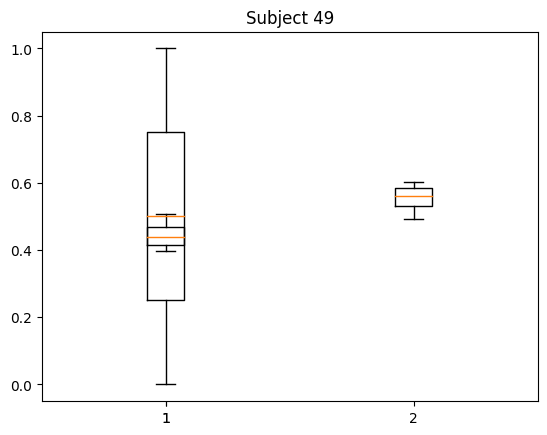

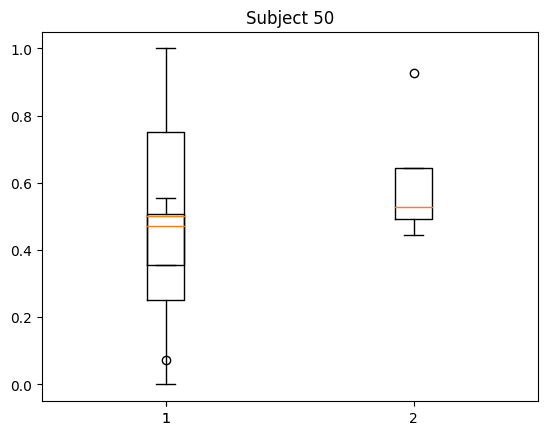

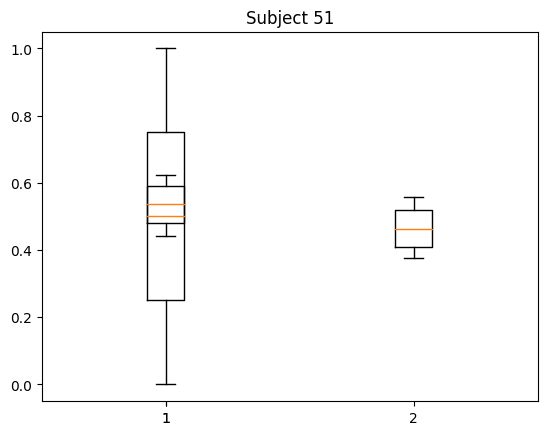

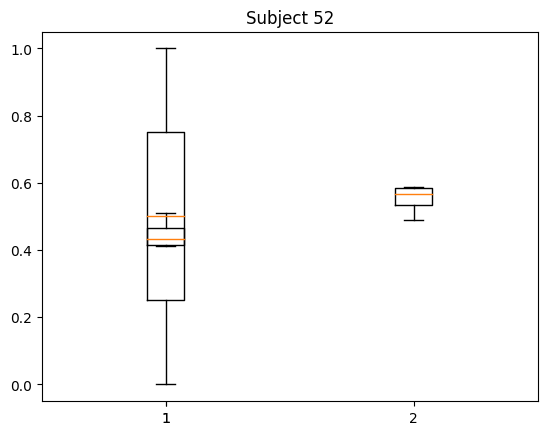

In [ ]:
#Bloxplot
for i in subjects:
    box_plot(i)

In [ ]:
def cam_subjets(subj):
    cams, y = load_cam_data(subj)
    results=[]
    for i,icam in enumerate(cams):
      results.append(icam[:,:,3,y[i]][...,None])
    return results

# TSNE

Nuevo modelo:

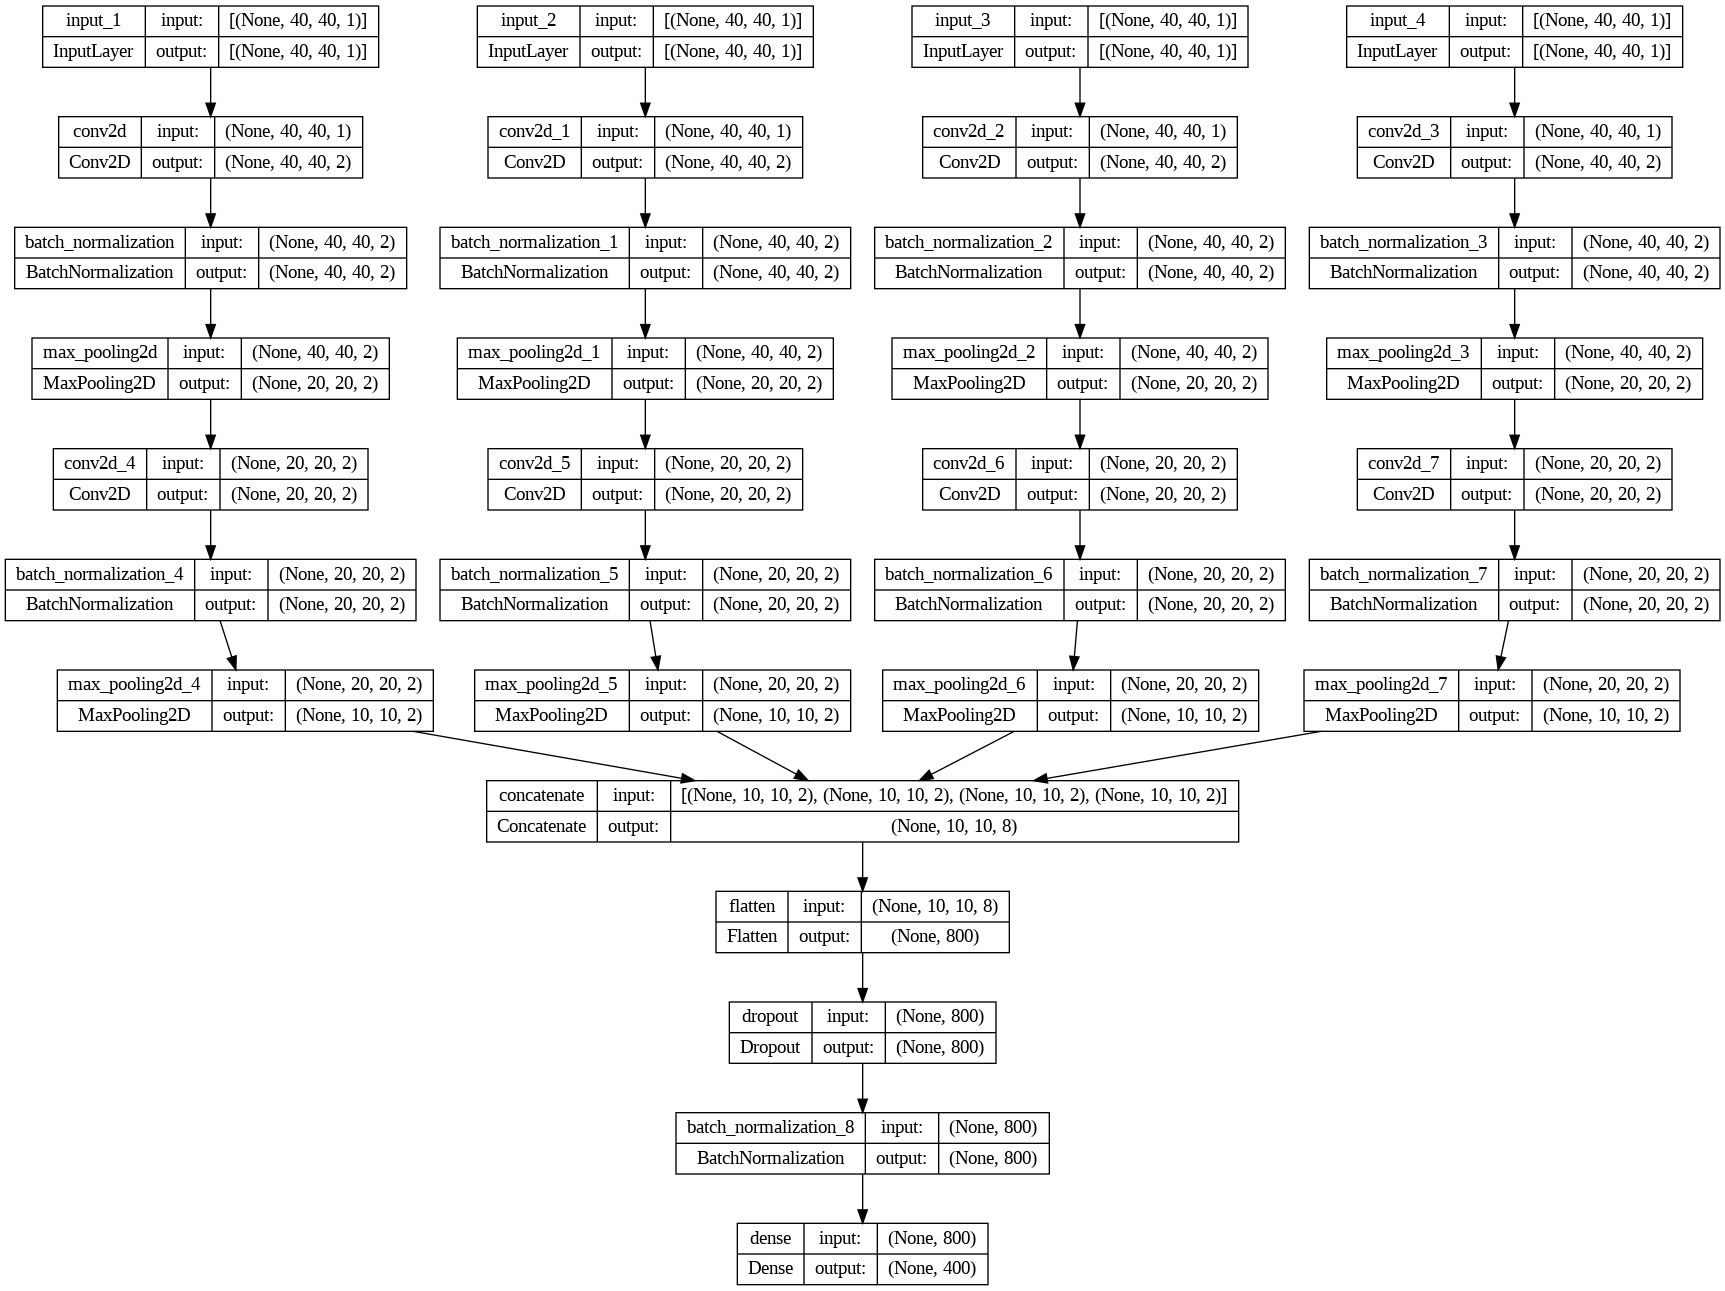

In [ ]:
model_s= tf.keras.models.load_model("/content/drive/MyDrive/Alejandra/PRUEBAS WDCNN/Results_Prueba_laplacian_Todos/Models/subject_43.h5")
model_shortened= tf.keras.Model(inputs=model_s.inputs,outputs=model_s.get_layer('dense').output)
tf.keras.utils.plot_model(model_shortened,show_shapes=True)

In [ ]:
Tsne_subjs=[]
for sbj in subjects:
  print('TSNE: ',sbj)
  model, X_gk, y= load_data(sbj)
  Xtrain, Xtest, ytrain,ytest = train_test_split(X_gk,y,test_size=0.2,random_state=0)
  Xtest, ytest = data_to_wdcnn_format( Xtest,ytest)
  #print(Xtest,sbj)
  model_shortened=load_model_short(model)
  sca_r = MinMaxScaler()
  red_r = TSNE(n_components=2,perplexity=5,learning_rate='auto',init='pca',random_state=123)
  ztsne = red_r.fit_transform(sca_r.fit_transform(model_shortened.predict( Xtest)))
  Tsne_subjs.append(ztsne)

TSNE:  1
2/2 [==============================] - 1s 22ms/step
TSNE:  2
2/2 [==============================] - 0s 25ms/step
TSNE:  3
2/2 [==============================] - 0s 14ms/step
TSNE:  4
2/2 [==============================] - 0s 15ms/step
TSNE:  5


2/2 [==============================] - 0s 16ms/step
TSNE:  6


2/2 [==============================] - 0s 14ms/step
TSNE:  7
2/2 [==============================] - 0s 24ms/step
TSNE:  8
2/2 [==============================] - 0s 15ms/step
TSNE:  9
2/2 [==============================] - 0s 24ms/step
TSNE:  10
2/2 [==============================] - 0s 13ms/step
TSNE:  11
2/2 [==============================] - 0s 14ms/step
TSNE:  12
2/2 [==============================] - 0s 10ms/step
TSNE:  13
2/2 [==============================] - 0s 16ms/step
TSNE:  14
2/2 [==============================] - 0s 14ms/step
TSNE:  15
2/2 [==============================] - 0s 15ms/step
TSNE:  16
2/2 [==============================] - 0s 23ms/step
TSNE:  17
2/2 [==============================] - 0s 14ms/step
TSNE:  18
2/2 [==============================] - 0s 14ms/step
TSNE:  19
1/1 [==============================] - 1s 662ms/step
TSNE:  20
1/1 [==============================] - 0s 471ms/step
TSNE:  21
2/2 [==============================] - 1s 22ms/step
TSNE:  22
2/2 [====

In [ ]:
def tsne_suj(numero_sujeto):
  print('TSNE:',numero_sujeto)
  model, X_gk, y= load_data(numero_sujeto)
  Xtrain, Xtest, ytrain,ytest = train_test_split(X_gk,y,test_size=0.2,random_state=0)
  Xtest, ytest = data_to_wdcnn_format( Xtest,ytest)
  model_shortened=load_model_short(model)
  sca_r = MinMaxScaler()
  red_r = TSNE(n_components=2,perplexity=15,learning_rate='auto',init='pca',random_state=123)
  ztsne = red_r.fit_transform(sca_r.fit_transform(model_shortened.predict( Xtest)))
  return ztsne

In [ ]:
cam17=cam_subjets(17)
subj17=tsne_suj(17)

TSNE: 17
2/2 [==============================] - 0s 15ms/step


In [ ]:
cam43=cam_subjets(43)
subj43=tsne_suj(43)

TSNE: 43
2/2 [==============================] - 0s 20ms/step


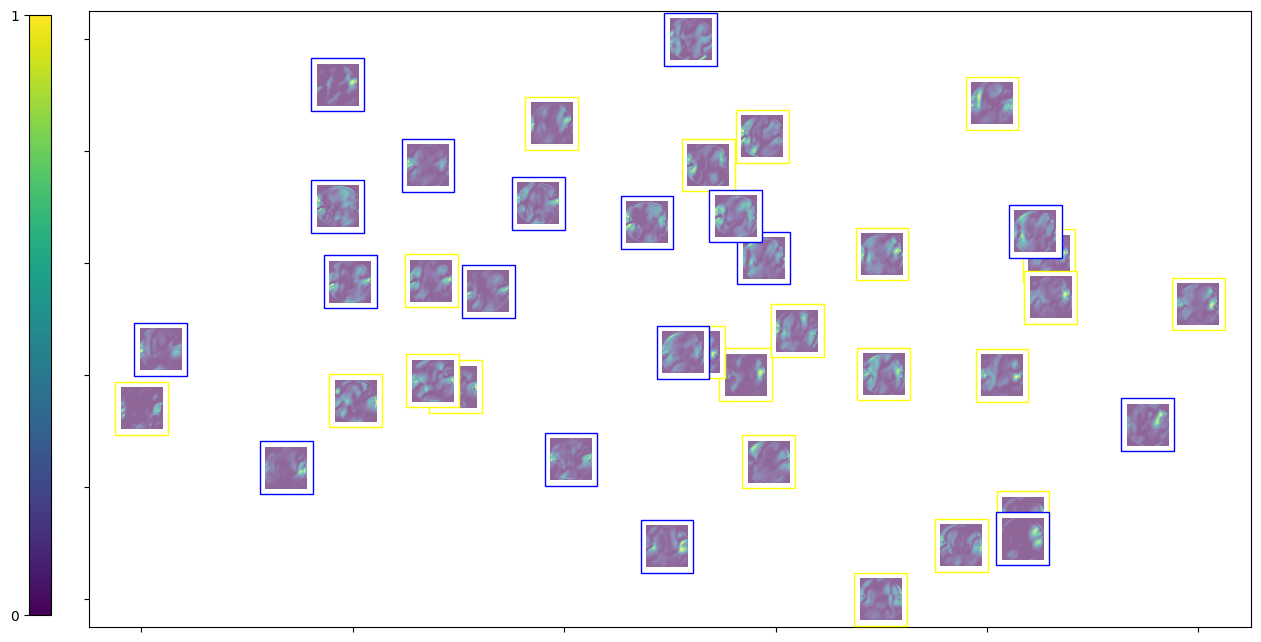

In [ ]:
figsize=(15,8)

plot_digits(subj17, ytest, min_distance=0.005, zoom= 0.75, images=cam17,s=80,
            figsize=figsize,colorbar ='left') #mnist samples

path = '/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2'
plt.savefig(path+'Subj17_tsne.png', bbox_inches='tight')
plt.show()

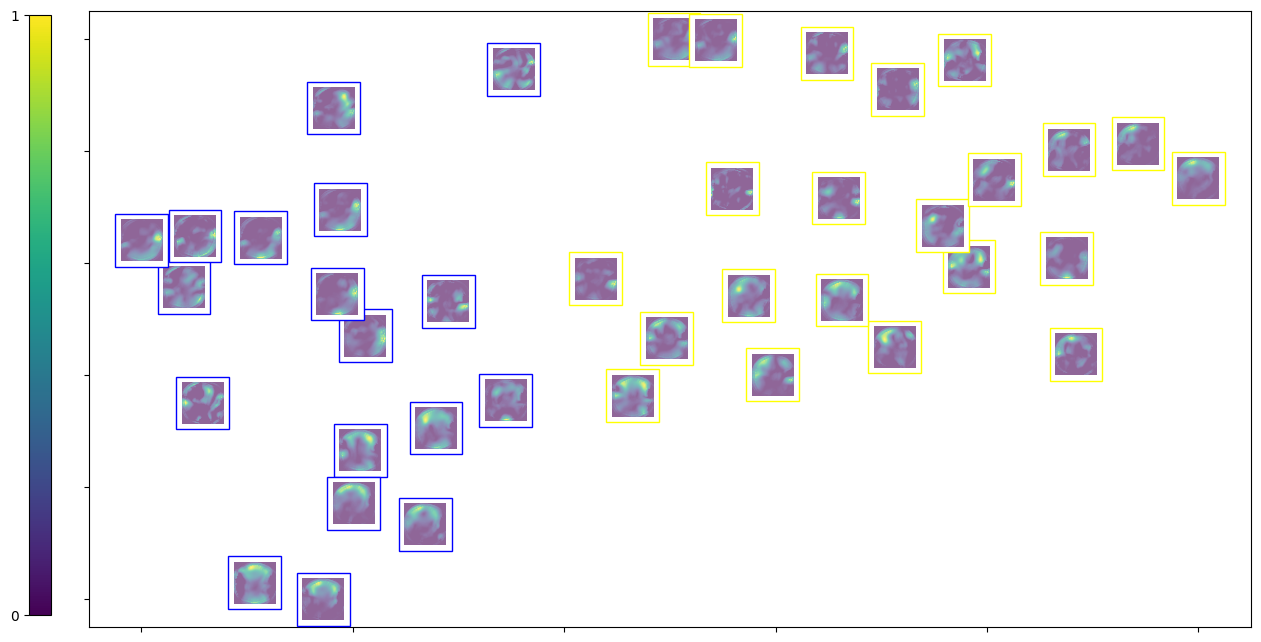

In [ ]:
figsize=(15,8)

plot_digits(subj43, ytest, min_distance=0.005, zoom= 0.75, images=cam43,s=80,
            figsize=figsize,colorbar ='left') #mnist samples
path = '/content/drive/Shareddrives/GFC + WDCNN/Pruebas WDCNN2'
plt.savefig(path+'Subj43_tsne.png', bbox_inches='tight')
plt.show()